In [1]:
import os
import csv
import gzip
import collections
import re
import io
import json
import pickle
from tqdm import tqdm
import xml.etree.ElementTree as ET
import zipfile
import requests
import pandas as pd
from tqdm import tqdm
import pubchempy as pcp
from rdkit.Chem import PandasTools
from rdkit.Chem import SDMolSupplier
from rdkit.Chem import MolFromSmiles
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from random import randrange, choice
from threading import Thread

In [2]:
### KL Divergence Computation
import numpy as np

def KL_aux(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

#### KL Divergence for incompatible distributions (input: Series for each dataset)
def KL(x,y):
    x = x.value_counts().sort_index()
    y = y.value_counts().sort_index()
    index = x.index.union(y.index).unique()
    x = x.reindex(index).fillna(1)
    y = y.reindex(index).fillna(1)
    x = x/x.values.sum()
    y = y/y.values.sum()
    return KL_aux(x,y)

In [61]:
def get_text(element, tag):
    e = element.find(tag)
    if e is not None:
        return e.text
    else:
        return ''

database = open("../Datasets/DrugBank/full database.xml", 'r')
tree = ET.parse(database)
root = tree.getroot()
print("Total drug entities: {}".format(len(root)))

### Read Structures from SDF format
structures_df = PandasTools.LoadSDF("../Datasets/DrugBank/structures.sdf")
print("Total drugs on Stuctures (MOL) supplementary file: {}".format(structures_df.shape[0]))

### Read Structures in CSV Format (fewer columns)
#structures_df = pd.read_csv("../Datasets/DrugBank/structure links.csv")  

### Add mol2vec vectors to structures_df
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# Compute mol2vec vectors for all smiles 
print("Computing mol2vec embeddings for all available MOL structures")
#Constructing sentences
structures_df['sentence'] = structures_df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
structures_df['mol2vec'] = [DfVec(x) for x in sentences2vec(structures_df['sentence'], model, unseen='UNK')]
# Keep track of Drugbank IDs for which we have MOL structure data
valid_ids = set(structures_df.DRUGBANK_ID.unique())

Total drug entities: 14594
Total drugs on Stuctures (MOL) supplementary file: 11290
Computing mol2vec embeddings for all available MOL structures


In [62]:
### Parse DrugBank Database to find interactions
total_drugs = 0
interactions_dict = {}
groups_dict = {}
name_dict = {}
kingdom_dict = {}
superclass_dict = {}
categories_dict = {}
for drug in tqdm(root, total = len(root)):
    total_drugs += 1

     #---------drugbank-id --------
    dbid = drug.find("{http://www.drugbank.ca}drugbank-id")
    #print(dbid.text)
    current_id = dbid.text

    name = drug.find("{http://www.drugbank.ca}name")
    if name is not None:
        #print(name.text)
        name_dict[current_id] = name.text

    #-----------------Interactions -----
    interactions = drug.find("{http://www.drugbank.ca}drug-interactions")
    
    interaction_list = []
    for t in interactions:
        i = t.find("{http://www.drugbank.ca}drugbank-id")
        #print(i.text)
        interaction_list.append(i.text)

    interactions_dict[current_id] = interaction_list

     #-----------------External Identifiers -----
    ext_identifiers = drug.find("{http://www.drugbank.ca}external-identifiers")
    
    interaction_list = []
    for t in interactions:
        i = t.find("{http://www.drugbank.ca}drugbank-id")
        #print(i.text)
        interaction_list.append(i.text)

    #------------------Drug Classification
    classification = drug.find("{http://www.drugbank.ca}classification")
    if classification is not None:
        kingdom = classification.find("{http://www.drugbank.ca}kingdom").text
        kingdom_dict[current_id] = kingdom
        superclass = classification.find("{http://www.drugbank.ca}superclass").text
        superclass_dict[current_id] = superclass
    
    #-----------------Drug Category (Amino Acids)
    categories = drug.find("{http://www.drugbank.ca}categories")
    if categories is not None:
        category = categories.find("{http://www.drugbank.ca}category")
        if category is not None:
            categories_string = category.find("{http://www.drugbank.ca}category").text
            categories_dict[current_id] = list(map(lambda x : x if ("and " not in x) else x.split('and ')[1], categories_string.split(';')))
    
    #----------------Drug Groups (e.g. Approved)
    groups = drug.find("{http://www.drugbank.ca}groups")
    if groups is not None:
        groups = groups.find("{http://www.drugbank.ca}group").text.split(';')
        groups_dict[current_id] = groups[0]
        if len(groups) > 1 :
            print(current_id) # check if any drug belongs to more than one group
            break

### Create Dataframes for drugs and interactions
drugs_df = pd.DataFrame(name_dict.items(), columns=['DrugbankId', 'Name'])
drugs_df['Group'] = drugs_df.DrugbankId.map(groups_dict)
drugs_df['Kingdom'] = drugs_df.DrugbankId.map(kingdom_dict)
drugs_df['Superclass'] = drugs_df.DrugbankId.map(superclass_dict)
drugs_df['Categories'] = drugs_df.DrugbankId.map(categories_dict)
interactions_df = pd.DataFrame(interactions_dict.items(), columns=['SDID', 'ODID'])
interactions_df = interactions_df.explode('ODID')

100%|██████████| 14594/14594 [00:03<00:00, 4859.31it/s]


In [4]:
### Set of unsupported DIDs:
interaction_dids = set(interactions_df.SDID.unique())
unsupported_ids = interaction_dids.difference(valid_ids)
print("Unsupported IDs: {}".format(len(unsupported_ids)))

Unsupported IDs: 3304


In [5]:
did2smiles = {}
### Use PubChem for each unsupported ID
for uid in tqdm(unsupported_ids, total = len(unsupported_ids)):
    res_list = pcp.get_compounds(name_dict[uid], 'name')
    if len(res_list) == 0: 
        continue
    did2smiles[uid] = res_list[0].isomeric_smiles
print("Fetched SMILES from PubChemPy: {} / {}".format(len(did2smiles.keys()), len(unsupported_ids)))
### Append new SMILES to structures_df
new_structures = pd.DataFrame(did2smiles.items(), columns=['DATABASE_ID', 'SMILES'])
new_structures['ROMol'] = new_structures['SMILES'].apply(lambda x: MolFromSmiles(x))
if new_structures[new_structures['ROMol'].isnull()].shape[0] > 0:
    print('Warining: could not convert the following SMILES to Chm.Mol: \n{}'.format(new_structures[new_structures['ROMol'].isnull()]))
    print("Droping substances that were not converted.")
    new_structures = new_structures.dropna()
structures_df = structures_df.append(new_structures)
### Update unsupported IDs
valid_ids = set(structures_df.DATABASE_ID.unique())
unsupported_ids = interaction_dids.difference(valid_ids)
### Compute Mol2Vec for all structures again (to cover new entries from PubChem)
structures_df['sentence'] = structures_df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
structures_df['mol2vec'] = [DfVec(x) for x in sentences2vec(structures_df['sentence'], model, unseen='UNK')]

100%|██████████| 3304/3304 [44:09<00:00,  1.25it/s]  


Fetched SMILES from PubChemPy: 454 / 3304
Warining: could not convert the following SMILES to Chm.Mol: 
    DATABASE_ID                                  SMILES ROMol
328     DB01929  C1=CC2=C(C(=C1N)Cl(=O)=O)C(=NC(=N2)N)N  None
Droping substances that were not converted.


In [6]:
#### Organizing Available Data
print("Valid IDs with SMILES")
# Remove from interactions dataframe unsupported ids
valid_interactions = interactions_df[interactions_df['SDID'].isin(valid_ids)]
valid_interactions = valid_interactions[valid_interactions['ODID'].isin(valid_ids)]
print("Total Valid Interactions: {} (from original {} interactions)".format(valid_interactions.shape[0], interactions_df.shape[0]))
print("Total Valid Drug IDs: {}".format(len(valid_ids)))

Valid IDs with SMILES
Total Valid Interactions: 2414352 (from original 2778368 interactions)
Total Valid Drug IDs: 11743


In [7]:
##### Mol2Vec Experiment Setup

#### Prepare a dataframe for the classification problem {col1: features_vector, col2: call_value}. 
#### features vector: concatenated features_vectors of two substances. Values: 0-->do not interact, 1-->interact
id2mol2vec = dict(zip(structures_df.DATABASE_ID, structures_df.mol2vec))
classification_df = pd.DataFrame({'features_vector':valid_interactions.apply(lambda r: [str(r.SDID), str(r.ODID)], axis = 1)})
mask = [(x[0] < x[1]) for x in classification_df['features_vector']]
classification_df = classification_df[mask] # Keep only one relation per drug interaction (A-->B, discard B-->A)
classification_df['class'] = 1 
classification_df['SDID'] =  classification_df.apply(lambda r: r.features_vector[0], axis=1)
classification_df['ODID'] =  classification_df.apply(lambda r: r.features_vector[1], axis=1)
classification_df['features_vector'] = classification_df.apply(lambda r: np.concatenate([id2mol2vec[r.features_vector[0]].vec, id2mol2vec[r.features_vector[1]].vec]), axis=1)
print("Classification DF shape:{}".format(classification_df.shape))

Classification DF shape:(1207176, 4)


In [3]:
### SAVE Data from Pickles --- folder: drugbank_experiment_pickles
# with open('drugbank_experiment_pickles/structures_df.pickle', 'wb') as handle:
#     pickle.dump(structures_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('drugbank_experiment_pickles/valid_interactions.pickle', 'wb') as handle:
#     pickle.dump(valid_interactions, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('drugbank_experiment_pickles/classification_df.pickle', 'wb') as handle:
#     pickle.dump(classification_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('drugbank_experiment_pickles/valid_ids.pickle', 'wb') as handle:
#     pickle.dump(valid_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('drugbank_edge_betweeness_centrality.pickle', 'wb') as handle:  # Store betweeness centrality of graph
#     pickle.dump(edge_betweeness_centrality, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('drugbank_groups_dict_centrality.pickle', 'wb') as handle:  # Store betweeness centrality of graph
#     pickle.dump(groups_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


### LOAD Data from Pickles --- folder: drugbank_experiment_pickless

with open('drugbank_experiment_pickles/structures_df.pickle', 'rb') as handle:
    structures_df = pickle.load(handle)

with open('drugbank_experiment_pickles/valid_interactions.pickle', 'rb') as handle:
    valid_interactions = pickle.load(handle)

with open('drugbank_experiment_pickles/classification_df.pickle', 'rb') as handle:
    classification_df = pickle.load(handle)

with open('drugbank_experiment_pickles/valid_ids.pickle', 'rb') as handle:
    valid_ids = pickle.load(handle)
    
with open('drugbank_edge_betweeness_centrality.pickle', 'rb') as handle:
    edge_betweeness_centrality = pickle.load(handle) 

with open('drugbank_groups_dict_centrality.pickle', 'rb') as handle:
    groups_dict = pickle.load(handle) 

In [23]:
### Create Negative Samples
# Add samples with substances that do not interact
# Generate random tuples from the substances list, and if they do not appear on the interactions_df add them as a non interaction

def getSetWithAllPairs(df, col1, col2):
    return set(list(zip(df[col1],df[col2])))
 
def getNegSamples(pairs_to_avoid, substances_df, neg_sample_size, result_list, result_idx, bad_cids):
    subs_did_list = list(set(valid_interactions.SDID.unique()).union(valid_interactions.ODID.unique()))
    neg_examples = []
    while len(neg_examples) < neg_sample_size:
        # Generate random pair
        did_a = choice(subs_did_list)
        did_b = choice(subs_did_list)
        if((did_a in bad_cids) or (did_b in bad_cids)):
            continue
        flag1 = (did_a, did_b) not in pairs_to_avoid
        flag2 = (did_b, did_a) not in pairs_to_avoid
        if(did_a != did_b and flag1 and flag2):
            try:   
                neg_examples.append([did_a, did_b, 0])
            except IndexError:
                print("IndexError for subject: {} and object: {}".format(did_a, did_b))
    result_list[result_idx-1] = neg_examples
    return

thread_list = []
NEG_SAMPLE_SIZE = 350000 # For each thread
THREADS = 4
result_list = [None]*THREADS
pairs_2_avoid = getSetWithAllPairs(valid_interactions, 'SDID', 'ODID')
bad_cids = {}
print("Initiating Multithreading Execution")
for i in range(THREADS):
    thread = Thread(target = getNegSamples, args = [pairs_2_avoid,structures_df, NEG_SAMPLE_SIZE, result_list, i, bad_cids])
    thread_list.append(thread)
    thread.start()

for t in thread_list:
    t.join()

print("Exited Multithreaded Section")

neg_examples = []
for l in result_list:
    if l != None: neg_examples.extend(l)
            
cid2mol2vec = dict(zip(structures_df.DATABASE_ID, structures_df.mol2vec))
print("Creating Dataframe with negative samples")
neg_examples_df = pd.DataFrame(data = neg_examples, columns=['SDID', 'ODID', 'class'])
print("Removing Duplicate vectors") 
#Remove duplicates
neg_examples_df = neg_examples_df.drop_duplicates()

# Create features_vector column
print("Applying mapp to feature vectors")
neg_examples_df["features_vector"] = neg_examples_df.apply(lambda r: np.concatenate([cid2mol2vec[r.SDID].vec, cid2mol2vec[r.ODID].vec]), axis = 1)
mol2vec_neg_examples_df = neg_examples_df # store negative examples for cross evaluating with node2vec experiment

Initiating Multithreading Execution
Exited Multithreaded Section
Creating Dataframe with negative samples
Removing Duplicate vectors
Applying mapp to feature vectors


In [24]:
### Create Test Dataframe with positive and negative examples of interactions
test_dataframe = pd.concat([classification_df, neg_examples_df], axis=0)
print("Shape of Test Dataframe: {}".format(test_dataframe.shape))

Shape of Test Dataframe: (2527526, 4)


In [25]:
############################# Starting the Classification Experiments #########################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Function to recover bidirectional interactions
def addReverseVector(df):
    #m = (df['class'] == 1) #uncomment to add reverse vectors only for one class
    #df1 = df[m].copy()
    df1 = df.copy()
    df1['features_vector'] = df1.features_vector.apply(lambda x: np.concatenate([x[:len(x)//2], x[len(x)//2:]]))
    return  pd.concat([df, df1], axis=0)

# Separate features vector from class
test_df = test_dataframe[['features_vector', 'SDID', 'ODID', 'class']]
X = test_df.iloc[:, 0:-1]
y = test_df.iloc[:, -1]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=69)
trainDF = addReverseVector(pd.concat([X_train,y_train], axis=1))
X_train, y_train= trainDF.features_vector, trainDF['class']
testDF = addReverseVector(pd.concat([X_test,y_test], axis=1))
X_test, y_test, test_pairs = testDF.features_vector, testDF['class'],  testDF[['SDID', 'ODID']]
valDF = addReverseVector(pd.concat([X_val,y_val], axis=1))
X_val, y_val= valDF.features_vector, valDF['class']

print("Shape of X_train: {} ------ Class_0: {} -- Class_1: {}".format(X_train.shape,  y_train[(y_train.values==0)].count(), y_train[(y_train.values==1)].count()))
print("Shape of X_test: {}  ------ Class_0: {} -- Class_1: {}".format(X_test.shape, y_test[(y_test.values==0)].count(), y_test[(y_test.values==1)].count()))
print("Shape of X_val: {}  ------ Class_0: {}  -- Class_1: {}".format(X_val.shape, y_val[(y_val.values==0)].count(), y_val[(y_val.values==1)].count()))

Shape of X_train: (2878850,) ------ Class_0: 1502158
Shape of X_test: (1668168,)  ------ Class_0: 870700
Shape of X_val: (508034,)  ------ Class_0: 266288


Plotting counts for Train Data


<AxesSubplot:xlabel='class', ylabel='count'>

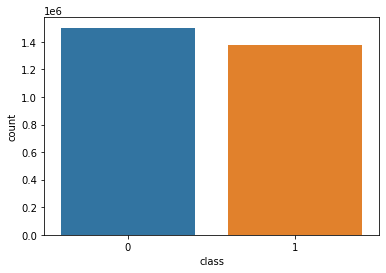

In [26]:
print("Plotting counts for Train Data")
sns.countplot(x = 'class', data=pd.DataFrame(data=y_train, columns=['class']))

Plotting counts for Validation Data


<AxesSubplot:xlabel='class', ylabel='count'>

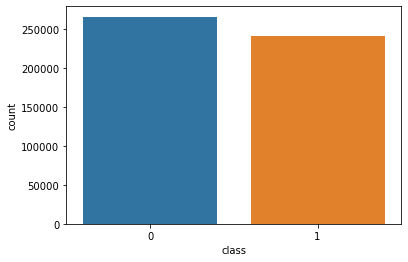

In [27]:
print("Plotting counts for Validation Data")
sns.countplot(x = 'class', data=pd.DataFrame(data=y_val, columns=['class']))

Plotting counts for Test Data


<AxesSubplot:xlabel='class', ylabel='count'>

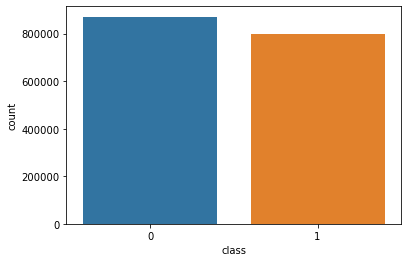

In [28]:
print("Plotting counts for Test Data")
sns.countplot(x = 'class', data=pd.DataFrame(data=y_test, columns=['class']))

In [29]:
## train dataclass TrainData(Dataset):

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train.values.tolist()), 
                       torch.FloatTensor(y_train.values.tolist()))
## test data    

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = TestData(torch.FloatTensor(X_test.values.tolist()))
val_data = TestData(torch.FloatTensor(X_val.values.tolist()))


C:\Users\user\AppData\Local\Temp/ipykernel_6460/1360306577.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_data = TrainData(torch.FloatTensor(X_train.values.tolist()),


In [30]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 600.
        self.layer_1 = nn.Linear(600, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_out = nn.Linear(256, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(256)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

class BinaryClassificationLarge(nn.Module):
    def __init__(self):
        super(BinaryClassificationLarge, self).__init__()        # Number of input features is 600.
        self.layer_1 = nn.Linear(600, 2048)
        self.layer_2 = nn.Linear(2048, 1024)
        self.layer_3 = nn.Linear(1024, 512)
        self.layer_4 = nn.Linear(512, 256)
        self.layer_out = nn.Linear(256, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(512)
        self.batchnorm4 = nn.BatchNorm1d(256)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

class BinaryClassificationFat(nn.Module):
    def __init__(self):
        super(BinaryClassificationFat, self).__init__()        # Number of input features is 600.
        self.layer_1 = nn.Linear(600, 4096)
        self.layer_2 = nn.Linear(4096, 2048)
        self.layer_out = nn.Linear(2048, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(4096)
        self.batchnorm2 = nn.BatchNorm1d(2048)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")
print(device)

# Define Model
model = BinaryClassification()
model.cuda()
print(model)
print("Model Size: ", model.__sizeof__())

cuda
BinaryClassification(
  (layer_1): Linear(in_features=600, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Model Size:  32


In [38]:
from sklearn.metrics import accuracy_score
### Train the model
# Model Parameters
EPOCHS = 70
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EARLY_STOPPING = 5

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
bad_progress_counter = 0
model_epoch = 0
best_val_acc = 0
# Create Loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader = DataLoader(dataset=val_data, batch_size=1)
print(device)

for e in range(1, EPOCHS+1):
    if e > 5:
        BATCH_SIZE = 32
        LEARNING_RATE = 0.0005
    elif e > 60:
        BATCH_SIZE = 16
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    # validation
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            y_val_pred = model(X_batch)
            y_val_pred = torch.sigmoid(y_val_pred)
            y_pred_tag = torch.round(y_val_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    val_acc = accuracy_score(y_pred_list, y_val)
    if e==1: 
        best_val_acc = val_acc
    elif best_val_acc <= val_acc:
        bad_progress_counter = 0
    else:
        bad_progress_counter +=1
    
    if bad_progress_counter == EARLY_STOPPING:
        print("Applying Early Stop")
        break
    # End of validation step
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val Acc: {val_acc}')
    if(val_acc > best_val_acc):
        mol2vec_model = model   #Store model
        model_epoch = e
        best_val_acc = val_acc
    
print("Keeping model from epoch: {}".format(model_epoch))

cuda
Epoch 001: | Loss: 0.25638 | Acc: 89.114 | Val Acc: 0.9002507706177145
Epoch 002: | Loss: 0.25644 | Acc: 89.143 | Val Acc: 0.9025065251538282
Epoch 003: | Loss: 0.25476 | Acc: 89.209 | Val Acc: 0.9007586106441695
Epoch 004: | Loss: 0.25512 | Acc: 89.180 | Val Acc: 0.8979162811937784
Epoch 005: | Loss: 0.25352 | Acc: 89.280 | Val Acc: 0.9031285307676258
Epoch 006: | Loss: 0.25374 | Acc: 89.251 | Val Acc: 0.9020616730376313
Epoch 007: | Loss: 0.25198 | Acc: 89.346 | Val Acc: 0.8990894310223332
Epoch 008: | Loss: 0.25112 | Acc: 89.376 | Val Acc: 0.8987863017042167
Epoch 009: | Loss: 0.25121 | Acc: 89.387 | Val Acc: 0.9017427967419503
Epoch 010: | Loss: 0.24973 | Acc: 89.448 | Val Acc: 0.9065968025762056
Epoch 011: | Loss: 0.24961 | Acc: 89.465 | Val Acc: 0.9053094871603081
Epoch 012: | Loss: 0.24879 | Acc: 89.499 | Val Acc: 0.9038725754575481
Epoch 013: | Loss: 0.24873 | Acc: 89.481 | Val Acc: 0.9043686052508296
Epoch 014: | Loss: 0.24782 | Acc: 89.540 | Val Acc: 0.9051520173846632
A

In [33]:
### Test the model
model = mol2vec_model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    870700
           1       0.88      0.91      0.89    797468

    accuracy                           0.90   1668168
   macro avg       0.90      0.90      0.90   1668168
weighted avg       0.90      0.90      0.90   1668168



<AxesSubplot:>

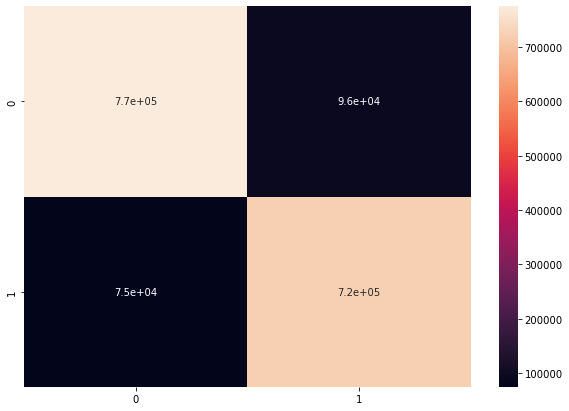

In [34]:
cm=confusion_matrix(y_test, y_pred_list)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [6]:
### SAVE Result Data
# with open('drugbank_experiment_pickles/mol2vec_large2_full_results.pickle', 'wb') as handle:
#     pickle.dump((test_pairs, y_test, y_pred_list), handle, protocol=pickle.HIGHEST_PROTOCOL)

### LOAD Data from Pickles --- folder: drugbank_experiment_pickless
with open('drugbank_experiment_pickles/mol2vec_large2_full_results.pickle', 'rb') as handle:
    test_pairs_m, y_test_m, y_pred_list_m = pickle.load(handle)
test_pairs, y_test, y_pred_list = test_pairs_m, y_test_m, y_pred_list_m

In [7]:
from statistics import mean
###### Compute Useful Test Results regadring Graph Properites on the Test Set's Nodes
# test_pairs, degreeNodes, y_test, y_pred
correct_degrees, min_correct_degrees, max_correct_degrees = [], [], []
false_degrees, min_false_degrees, max_false_degrees = [], [], []
correct_core_diffs, false_core_diffs = [], []
correct_b_centrality, false_b_centrality = [], []
pairs = test_pairs.values
test_values = y_test.values
for i in range(len(pairs)):
    scid, ocid = pairs[i][0], pairs[i][1]
    sdegree, odegree = degreeNodes[scid], degreeNodes[ocid]
    score, ocore = core_dict[scid], core_dict[ocid]
    if int(test_values[i]) == int(y_pred_list[i]):   # Correct decision for NN
        correct_degrees.append(1.0*(sdegree + odegree)/2)
        min_correct_degrees.append(min(sdegree, odegree))
        max_correct_degrees.append(max(sdegree, odegree))
        correct_core_diffs.append(abs(score-ocore))
        try: # will only work if edge really exists 
            correct_b_centrality.append(edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)])
        except:
            continue
    else:
        false_degrees.append(1.0*(sdegree + odegree)/2)
        min_false_degrees.append(min(sdegree, odegree))
        max_false_degrees.append(max(sdegree, odegree))
        false_core_diffs.append(abs(score-ocore))
        try: # will only work if edge really exists 
            false_b_centrality.append(edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)])
        except:
            continue

print("Mean Correct Degrees: {}".format(mean(correct_degrees)))
print("Mean MIN Correct Degrees: {}".format(mean(min_correct_degrees)))
print("Mean MAX Correct Degrees: {}".format(mean(max_correct_degrees)))
print("Mean Correct Core Differences: {}".format(mean(correct_core_diffs)))
print("Mean Correct Betweenus Centrality: {}".format(mean(correct_b_centrality)))
print("Mean False Degrees: {}".format(mean(false_degrees)))
print("Mean MIN False Degrees: {}".format(mean(min_false_degrees)))
print("Mean MAX False Degrees: {}".format(mean(max_false_degrees)))
print("Mean False Core Differences: {}".format(mean(false_core_diffs)))
print("Mean False Betweenus Centrality: {}".format(mean(false_b_centrality)))

Mean Correct Degrees: 801.4563186123078
Mean MIN Correct Degrees: 519.6601452683562
Mean MAX Correct Degrees: 1083.252491956259
Mean Correct Core Differences: 228.50635215016408
Mean Correct Betweenus Centrality: 1.388185973238613e-06
Mean False Degrees: 827.544405667865
Mean MIN False Degrees: 518.0624328866894
Mean MAX False Degrees: 1137.0263784490405
Mean False Core Differences: 237.17191512208785
Mean False Betweenus Centrality: 4.575102032375192e-06


In [8]:
### Prepare for Plots
resolution = 1000
b_centrality_limit = 3
distribution_dict = {}
for i in tqdm(range(len(pairs))):
   scid, ocid = pairs[i][0], pairs[i][1]
   sdegree, odegree = degreeNodes[scid], degreeNodes[ocid]
   score, ocore = core_dict[scid], core_dict[ocid]
   is_positive =  int(test_values[i])
   correctly_identified = int(test_values[i]) == int(y_pred_list[i])
   mean_degree = 1.0*(sdegree + odegree)/2
   min_degree = min(sdegree, odegree)
   max_degree = max(sdegree, odegree)
   core_diff = abs(score-ocore)
   try:
      b_centrallity = 10**6*edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)]
   except: 
      b_centrallity = None
   distribution_dict[(scid, ocid)] = [is_positive, correctly_identified, mean_degree, min_degree, max_degree, core_diff, b_centrallity]

distribution_df = pd.DataFrame.from_dict(data = distribution_dict, orient = 'index' , columns= ['is_positive', 'correctly_identified', 'mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality'])

100%|██████████| 1668168/1668168 [00:13<00:00, 127239.08it/s]


In [8]:
### Define parameters for results plots file save
resultsPath = "result_plots/large_drugbank_results/mol2vec/large_nn/"   ### CHANGE THIS FOR EVERY EXPERIMENT
metrics_dict = {"mean_degree":"Mean Degree", "min_degree":"Min Degree", "max_degree":"Max Degree", "core_diff":"Core Difference", "b_centrality":"Betweenness Centrality"}

### Plot Group A: Histogram grouped by categories in same plot
for x_axis_variable in ['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']:

    x1 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)]
    x2 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)]
    x3 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)]
    x4 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)]

    kwargs = dict(alpha=0.5, bins=100, density=False, stacked=True)
    if x_axis_variable != "b_centrality":
        plt.hist(x1, **kwargs, color='g', label='Negative Correctly Identified')
        plt.hist(x2, **kwargs, color='b', label='Negative Incorrectly Identified')
    else:
        x3 = x3[x3.between(0,b_centrality_limit)]
        x4 = x4[x4.between(0,b_centrality_limit)]
    plt.hist(x3, **kwargs, color='r', label='Positive Correctly Identified')
    plt.hist(x4, **kwargs, color='c', label='Positive Incorrectly Identified')
    plt.gca().set(title="Frequency Histogram of Classifier's predictions", ylabel='Frequency', xlabel = metrics_dict[x_axis_variable])
    # plt.xlim(50,75)
    plt.legend()
    imageName = "groupA_Frequency Histogram of Classifier's predictions_" + x_axis_variable
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

### Plot Group AX: Density grouped by categories in same plot
for x_axis_variable in ['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']:

    x1 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)]
    x2 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)]
    x3 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)]
    x4 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)]

    # Normalize
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
    if x_axis_variable != "b_centrality":
        plt.hist(x1, **kwargs, color='g', label='Negative Correctly Identified')
        plt.hist(x2, **kwargs, color='b', label='Negative Incorrectly Identified')
    else:
        x3 = x3[x3.between(0,b_centrality_limit)]
        x4 = x4[x4.between(0,b_centrality_limit)]
    plt.hist(x3, **kwargs, color='r', label='Positive Correctly Identified')
    plt.hist(x4, **kwargs, color='c', label='Positive Incorrectly Identified')
    plt.gca().set(title="Density Histogram of Classifier's predictions", ylabel='Density', xlabel = metrics_dict[x_axis_variable])
    # plt.xlim(50,75)
    plt.legend()
    imageName = "groupAX_Density Histogram of Classifier's predictions_" + x_axis_variable
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

   
### Plot Group B: Density grouped by categories in separate subplots

param_list = []
for pos in [0,1]:
    for corr in [True, False]:
        param_list.append((distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr))
titles = ['Negative Correctly Identified', 'Negative Incorrectly Identified', 'Positive Correctly Identified', 'Positive Incorrectly Identified']
colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:cyan']
for selector in ['mean_degree', 'min_degree', 'max_degree', 'core_diff']:
    fig, axes = plt.subplots(1, 4, figsize=(15,2.5), dpi=resolution, sharex=True, sharey=True)
    for i, (ax, param) in enumerate(zip(axes.flatten(), param_list)):
        x = distribution_df[selector][param]
        ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(titles[i]), color=colors[i])
        ax.set_title(titles[i])
        ax.set_ylabel = "Density"
        ax.set_xlabel = selector
    plt.suptitle('Classifier Predictions: Density of {}'.format(metrics_dict[selector]), y=1)
    plt.tight_layout()
    imageName = "groupB_Density Histogram of Classifier's predictions_" + selector
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

############# Repeat for Distributions that recognize only positive edges
param_list = []
for pos in [1]:
    for corr in [True, False]:
        param_list.append((distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr))
titles = ['Positive Correctly Identified', 'Positive Incorrectly Identified']

for selector in ['b_centrality']:
    fig, axes = plt.subplots(1, 2, figsize=(15,2.5), dpi=resolution, sharex=True, sharey=True)
    for i, (ax, param) in enumerate(zip(axes.flatten(), param_list)):
        x = distribution_df[selector][param]
        x = x[x.between(0,b_centrality_limit)]

        ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(titles[i]), color=colors[i])
        ax.set_title(titles[i])
        ax.set_ylabel = "Density"
        ax.set_xlabel = selector
    plt.suptitle('Classifier Predictions: Density of {}'.format(metrics_dict[selector]), y=1)
    plt.tight_layout()
    imageName = "groupB_Density Histogram of Classifier's predictions_" + selector
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

### Plot Group C: KDE 
titles = ['Negative Correctly Identified', 'Negative Incorrectly Identified', 'Positive Correctly Identified', 'Positive Incorrectly Identified']

for selector in ['mean_degree', 'min_degree', 'max_degree', 'core_diff']:
    dv_list = []
    i=0
    for pos in [0,1]:
        for corr in [True, False]:
            dv = distribution_df[selector][(distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr)].value_counts()
            #dv = dv/dv.sum()
            dv = dv.rename(titles[i]+ " -  " + selector)
            i += 1
            dv = dv.sort_index()
            dv_list.append(dv)

    dist_df = pd.concat(dv_list, axis=1)
    dist_df = pd.concat(dv_list, axis=1).fillna(0)
    kwargs = dict(title="Kernel Density Estimate for Classifier's Predictions: {}".format(metrics_dict[selector]), color=colors)
    figSrc = dist_df.plot.kde(**kwargs, bw_method=0.03)
    fig = figSrc.get_figure()
    imageName = "groupC_KDE of Classifier's predictions_" + selector
    fig.savefig(resultsPath + imageName + ".png", dpi=resolution, bbox_inches='tight')
    plt.close(fig)
    
    
    

############# Repeat for Distributions that recognize only positive edges
for selector in ['b_centrality']:
    dv_list = []
    i=2
    for pos in [1]:
        for corr in [True, False]:
            x = distribution_df[selector][(distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr)]
            x = x[x.between(0,b_centrality_limit)]
            dv = x.value_counts()
            #dv = dv/dv.sum()
            dv = dv.rename(titles[i]+ " -  " + selector)
            i += 1
            dv = dv.sort_index()
            dv_list.append(dv)
    dist_df = pd.concat(dv_list, axis=1)
    dist_df = pd.concat(dv_list, axis=1).fillna(0)
    kwargs = dict(title="Kernel Density Estimate for Classifier's Predictions: {}".format(metrics_dict[selector]), color=colors)
    figSrc = dist_df.plot.kde(**kwargs)
    fig = figSrc.get_figure()
    imageName = "groupC_KDE of Classifier's predictions_" + selector
    fig.savefig(resultsPath + imageName + ".png", dpi=resolution, bbox_inches='tight')
    plt.close(fig)

### Compute Stats
print("Total Negative Correctly Identified Samples:     {}".format(distribution_df[(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)].shape[0]))
print("Total Negative Incorrectly Identified Samples:   {}".format(distribution_df[(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)].shape[0]))
print("Total Positive Correctly Identified Samples:     {}".format(distribution_df[(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)].shape[0]))
print("Total Positive Incorrectly Identified Samples:   {}".format(distribution_df[(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)].shape[0]))

#### B-centrality-stats
print("\nB centrality plots where limited on samples with b_centrality < {}".format(b_centrality_limit))
print("Total nodes with b_centrality <  {}:   {}".format(b_centrality_limit, distribution_df[(distribution_df.b_centrality < b_centrality_limit)].shape[0]))
print("Total nodes with b_centrality >= {}:   {}".format(b_centrality_limit, distribution_df[(distribution_df.b_centrality >= b_centrality_limit)].shape[0]))


print("\nKL Divergence Results")
### KL Divergence Computation
print("KL Divergence between distributions from Classifier choices")
kl_list = []
for index, selector in enumerate(['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']):
    print("---" + selector + " ~ KL(Correct | False): {}"\
        .format(KL(distribution_df[distribution_df.correctly_identified==True][selector], distribution_df[distribution_df.correctly_identified==False][selector])))
    print("---" + selector + " ~ KL(False | Correct): {}"\
        .format(KL(distribution_df[distribution_df.correctly_identified==False][selector], distribution_df[distribution_df.correctly_identified==True][selector])))

####### Evaluate Model's Predictions on Drug Groups
distribution_df['sgroup'] = distribution_df.index.map(lambda x: groups_dict[x[0]])
distribution_df['ogroup'] =distribution_df.index.map(lambda x: groups_dict[x[1]])

# Print (ordered) Accuracy and total samples for each category (when at least one drug on the interaction belongs to a category)
group_names = ['approved', 'investigational', 'experimental', 'illicit', 'vet_approved', 'withdrawn', 'nutraceutical']

for name in group_names:
    temp_df = distribution_df[(distribution_df.sgroup==name) | (distribution_df.ogroup==name)]
    accuracy = temp_df[temp_df.correctly_identified==True].shape[0] / temp_df.shape[0]
    neg_samples = temp_df[((temp_df.sgroup==name) | (temp_df.ogroup==name)) & (temp_df.is_positive==0)].shape[0]
    positive_samples = temp_df[((temp_df.sgroup==name) | (temp_df.ogroup==name)) & (temp_df.is_positive==1)].shape[0]
    neg_acc =  temp_df[(temp_df.correctly_identified==True) & (temp_df.is_positive==0)].shape[0] / neg_samples
    pos_acc =  temp_df[(temp_df.correctly_identified==True) & (temp_df.is_positive==1)].shape[0] / positive_samples
    print("Total {} Drugs in Test Samples:  {} --- Model Accuracy {}".format(name, temp_df.shape[0], accuracy))
    print("\t\t{} Drugs in Positive Interactions: {}    Accuracy:{}".format(name, positive_samples, pos_acc))
    print("\t\t{} Drugs in Negative Interactions: {}    Accuracy:{}".format(name, neg_samples, neg_acc))

100%|██████████| 1668168/1668168 [00:12<00:00, 131874.64it/s]


Total Negative Correctly Identified Samples:     387254
Total Negative Incorrectly Identified Samples:   48096
Total Positive Correctly Identified Samples:     361154
Total Positive Incorrectly Identified Samples:   37580

B centrality plots where limited on samples with b_centrality < 3
Total nodes with b_centrality <  3:   380881
Total nodes with b_centrality >= 3:   17853

KL Divergence Results
KL Divergence between distributions from Classifier choices
---mean_degree ~ KL(Correct | False): 0.28905432867637165
---mean_degree ~ KL(False | Correct): 0.17764438627751333
---min_degree ~ KL(Correct | False): 0.3608011963433506
---min_degree ~ KL(False | Correct): 0.30323878090056133
---max_degree ~ KL(Correct | False): 0.22150053180377605
---max_degree ~ KL(False | Correct): 0.13355018137036834
---core_diff ~ KL(Correct | False): 0.2515681254522361
---core_diff ~ KL(False | Correct): 0.2000683739477416
---b_centrality ~ KL(Correct | False): 0.2232737016246336
---b_centrality ~ KL(False |

In [20]:
#### Model Accuracy for pairs with min_degree < N
N = distribution_df.max_degree.max()
print("Node2Vec Experiment Min Degree: {}".format(N))
mol2vec_min_degree_recall_list = []
mol2vec_min_degree_accuracy_list = []
for n in tqdm(range(1,N+1)):
    lddf = distribution_df[distribution_df.min_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    mol2vec_min_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    mol2vec_min_degree_accuracy_list.append(100.0*correct/(correct + false))

N = distribution_df.max_degree.max()
print("Node2Vec Experiment Mean Degree: {}".format(N))
mol2vec_mean_degree_recall_list = []
mol2vec_mean_degree_accuracy_list = []
for n in tqdm(range(6,N+1)):
    lddf = distribution_df[distribution_df.mean_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    mol2vec_mean_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    mol2vec_mean_degree_accuracy_list.append(100.0*correct/(correct + false))

N = distribution_df.max_degree.max()
print("Node2Vec Experiment Max Degree: {}".format(N))
mol2vec_max_degree_recall_list = []
mol2vec_max_degree_accuracy_list = []
for n in tqdm(range(11,N+1)):
    lddf = distribution_df[distribution_df.max_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    mol2vec_max_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    mol2vec_max_degree_accuracy_list.append(100.0*correct/(correct + false))

C = distribution_df.core_diff.max()
mol2vec_core_diff_recall_list = []
mol2vec_core_diff_accuracy_list = []
print("Node2Vec Experiment Max Core Difference: {}".format(C))
for c in tqdm(range(0,C+1)):
    lddf = distribution_df[distribution_df.core_diff <= c] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    mol2vec_core_diff_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    mol2vec_core_diff_accuracy_list.append(100.0*correct/(correct + false))

B = distribution_df.b_centrality.max()
mol2vec_b_centrality_recall_list = []
mol2vec_b_centrality_accuracy_list = []
print("Node2Vec Experiment b_centrality: {}".format(B))
for c in tqdm(np.arange(0.01,B+0.1, 0.1)):
    lddf = distribution_df[distribution_df.b_centrality <= c] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    mol2vec_b_centrality_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    mol2vec_b_centrality_accuracy_list.append(100.0*correct/(correct + false))

Node2Vec Experiment b_centrality: 950.2148558947254


100%|██████████| 9504/9504 [39:22<00:00,  4.02it/s]  


In [21]:
### Save distribution_df for mol2vec
m2v_distribution_df = distribution_df

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")
print(device)

cuda


Creating graph for relation: Interactions --- Nodes: 3753, Edges: 1207953
Size of connected components
#Connected components 1


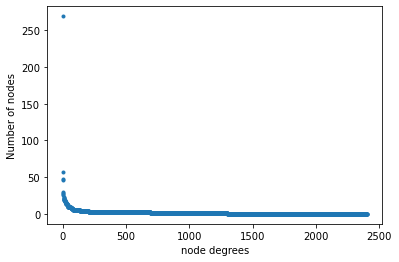

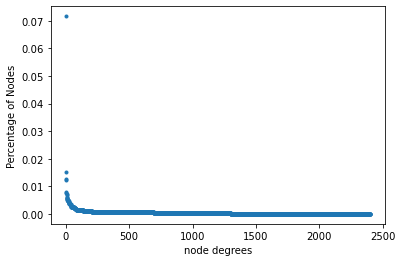

C:\Users\user\AppData\Local\Temp/ipykernel_21788/3391246012.py:43: RuntimeWarning: divide by zero encountered in log10
  plt.plot((np.arange(1,len(hg)+1)),sorted(np.log10(hg),reverse=True),'.')


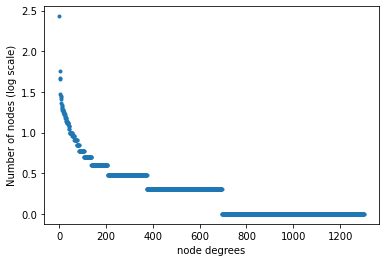

In [5]:
###################### GRAPH EMBEDDING EXPERIMENT ##########################
import networkx as nx
#cid_list = list(set(phsu_interacts_df.snode_cid.unique()).union(phsu_interacts_df.onode_cid.unique()))
nodes_df = valid_interactions.SDID.unique()
edges_df = valid_interactions[['SDID','ODID']]

interactions_graph=nx.from_pandas_edgelist(edges_df, "SDID", "ODID")
print("Creating graph for relation: Interactions --- Nodes: {}, Edges: {}".format(len(interactions_graph.nodes()), len(interactions_graph.edges())))

######## Study the Graph

#print the conneted components
print ('Size of connected components')
comp=list(nx.connected_components(interactions_graph))
print ('#Connected components', nx.number_connected_components(interactions_graph))

#degree centrality
degreeNodes=dict(nx.degree(interactions_graph))

# core degrees of Nodes
temp_graph = nx.Graph.copy(interactions_graph)
temp_graph.remove_edges_from(nx.selfloop_edges(temp_graph))
core_dict = nx.algorithms.core.core_number(temp_graph)

# edge betweeness centrality --- Loaded from pickle
# edge_betweeness_centrality = nx.algorithms.centrality.edge_betweenness_centrality(interactions_graph)

# a histogram
hg=nx.degree_histogram(interactions_graph)
plt.plot(sorted(hg,reverse=True),'.')
plt.xlabel('node degrees')
plt.ylabel('Number of nodes')
plt.show()

numberOfNodes = np.sum(hg)
hg=nx.degree_histogram(interactions_graph)
plt.plot(sorted(hg,reverse=True)/numberOfNodes,'.')
plt.xlabel('node degrees')
plt.ylabel('Percentage of Nodes')
plt.show()

hg=nx.degree_histogram(interactions_graph)
plt.plot((np.arange(1,len(hg)+1)),sorted(np.log10(hg),reverse=True),'.')
plt.xlabel('node degrees')
plt.ylabel('Number of nodes (log scale)')
plt.show()



In [44]:
nx.diameter(interactions_graph)

5

In [45]:
### Randomly remove edges
from random import sample
from math import floor
REMOVE_FACTOR = 0.99
print("All edges: {}".format(len(interactions_graph.edges())))
to_remove=sample(interactions_graph.edges(),k=floor(REMOVE_FACTOR*len(interactions_graph.edges()))) #removing of edges
interactions_graph_filtered = interactions_graph.copy()
interactions_graph_filtered.remove_edges_from(to_remove)
print("Total edges after removing random samples: {}".format(len(interactions_graph_filtered.edges())))
# print(G.edges())
removed_set = set(to_remove)

All edges: 1207953


C:\Users\user\AppData\Local\Temp/ipykernel_15732/1991475543.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  to_remove=sample(interactions_graph.edges(),k=floor(REMOVE_FACTOR*len(interactions_graph.edges()))) #removing of edges


Total edges after removing random samples: 12080


Size of connected components
#Connected components 799


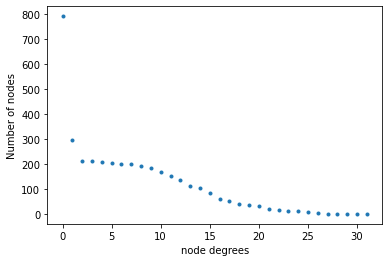

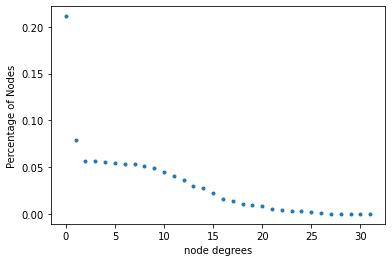

C:\Users\user\AppData\Local\Temp/ipykernel_15732/1898195536.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot((np.arange(1,len(hg)+1)),sorted(np.log10(hg),reverse=True),'.')


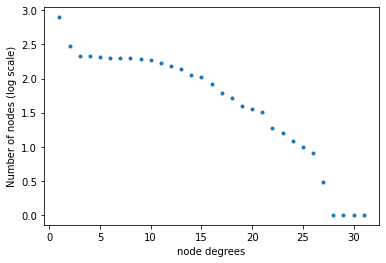

In [46]:
######## Study the Filtered Graph

#print the conneted components
print ('Size of connected components')
comp=list(nx.connected_components(interactions_graph_filtered))
print ('#Connected components', nx.number_connected_components(interactions_graph_filtered))

#degree centrality
degreeNodesFiltered=dict(nx.degree(interactions_graph_filtered))

# core degrees of Nodes
temp_graph = nx.Graph.copy(interactions_graph_filtered)
temp_graph.remove_edges_from(nx.selfloop_edges(temp_graph))
core_dictFiltered = nx.algorithms.core.core_number(temp_graph)

# a histogram
hg=nx.degree_histogram(interactions_graph_filtered)
plt.plot(sorted(hg,reverse=True),'.')
plt.xlabel('node degrees')
plt.ylabel('Number of nodes')
plt.show()

numberOfNodes = np.sum(hg)
hg=nx.degree_histogram(interactions_graph_filtered)
plt.plot(sorted(hg,reverse=True)/numberOfNodes,'.')
plt.xlabel('node degrees')
plt.ylabel('Percentage of Nodes')
plt.show()

hg=nx.degree_histogram(interactions_graph_filtered)
plt.plot((np.arange(1,len(hg)+1)),sorted(np.log10(hg),reverse=True),'.')
plt.xlabel('node degrees')
plt.ylabel('Number of nodes (log scale)')
plt.show()


In [47]:
nx.diameter(interactions_graph_filtered)

NetworkXError: Found infinite path length because the graph is not connected

In [12]:
#from node2vec import Node2Vec
from nodevectors import Node2Vec
# Generate walks with Original Node2Vec
# node2vec = Node2Vec(interactions_graph_filtered, dimensions=128, walk_length=16, num_walks=100, workers = 1)
# model = node2vec.fit(window=10, min_count=1)

# Generate walks with Graph2Vec (nodevectors lib)
# Fit embedding model to graph
g2v = Node2Vec(n_components=128, walklen=16, epochs=100)
# way faster than other node2vec implementations
# Graph edge weights are handled automatically
g2v.fit(interactions_graph_filtered)

Making walks... Done, T=4.24
Mapping Walk Names... Done, T=2.63
Training W2V... Done, T=116.52


In [13]:
node_ids = g2v.model.wv.index2word  # list of node IDs
# perform conversion of ids to ints
node_ids = list(node_ids)
embedding_vectors = g2v.model.wv.vectors
n2v_df = pd.DataFrame(list(zip(node_ids, embedding_vectors)),columns=['DATABASE_ID','node2vec'])
# using dictionary comprehension
# to convert lists to dictionary
cid2node_vec_dict = {node_ids[i]: embedding_vectors[i] for i in range(len(node_ids))}
### uddate substances df with node2vec vector
structures_df["node2vec"] = structures_df["DATABASE_ID"].map(cid2node_vec_dict)
########### RUN UP TO THIS CELL FOR HYBRID EXPERIMENT ##############################

In [14]:
from tqdm import tqdm
from random import random
#### Create Classification Dataframe with true samples {features_vector, 1} ####
classification_train_rows_list = []
classification_test_rows_list = []
MOVE_TO_TRAIN_PROB = 0.50

for index, row in tqdm(valid_interactions.iterrows(), total=valid_interactions.shape[0]):
    s_node2vec = cid2node_vec_dict[row['SDID']]
    scid = row['SDID']
    o_node2vec = cid2node_vec_dict[row['ODID']]
    ocid = row['ODID']
    is_test = (row['SDID'],row['ODID']) in removed_set or (row['ODID'], row['SDID']) in removed_set
    try:   
        fv_direct = np.concatenate((s_node2vec.tolist(), o_node2vec.tolist()))
        if is_test and (random() > MOVE_TO_TRAIN_PROB): # with prob to move to train
            # fv_opposite = np.concatenate((o_node2vec, s_node2vec)) ### track opposite direction of interacts relationship
            classification_test_rows_list.append([fv_direct, 1, scid, ocid])
            # classification_test_rows_list.append([fv_opposite, 1])  ### opposite is not needed since neo4j contains reverse of each edge
        else:
            classification_train_rows_list.append([fv_direct, 1, scid, ocid])
    except IndexError:
        print("IndexError on index: {} for subject: {} and object: {}".format(index, s_node2vec, o_node2vec))

    
classification_train_df = pd.DataFrame(data = classification_train_rows_list, columns=['features_vector', 'class', 'SDID', 'ODID']) 
classification_test_df = pd.DataFrame(data = classification_test_rows_list, columns=['features_vector', 'class', 'SDID', 'ODID']) 
# Remove duplicates
#classification_df = classification_df[~classification_df['features_vector'].apply(tuple).duplicated()]
print("Classification Train DF shape:{}".format(classification_train_df.shape))
print("Classification Test DF shape:{}".format(classification_test_df.shape))

100%|██████████| 2415906/2415906 [04:54<00:00, 8194.04it/s] 


Classification Train DF shape:(1218924, 4)
Classification Test DF shape:(1196982, 4)


In [15]:
from random import randrange, choice
# Add samples with substances that do not interact
# Generate random tuples from the substances list, and if they do not appear on the interactions_df add them as a non interaction

def getSetWithAllPairs(df, col1, col2):
    return set(list(zip(df[col1],df[col2])))
 
def getNegSamples(pairs_to_avoid, substances_df, neg_sample_size, result_list, result_idx, bad_cids):
    subs_cid_list = list(set().union(valid_interactions['SDID'].unique(), valid_interactions['ODID'].unique()))
    neg_examples = []
    while len(neg_examples) < neg_sample_size:
        # Generate random pair
        cid_a = choice(subs_cid_list)
        cid_b = choice(subs_cid_list)
        if((cid_a in bad_cids) or (cid_b in bad_cids)):
            continue
        # flag1 = not phsu_interacts_df.loc[(phsu_interacts_df['snode_cid'] == cid_a) & (phsu_interacts_df['onode_cid'] == cid_b)].any().all()
        # flag2 = not phsu_interacts_df.loc[(phsu_interacts_df['snode_cid'] == cid_b) & (phsu_interacts_df['onode_cid'] == cid_a)].any().all()
        flag1 = (cid_a, cid_b) not in pairs_to_avoid
        flag2 = (cid_b, cid_a) not in pairs_to_avoid
        if(cid_a != cid_b and flag1 and flag2):
            s_node2vec = cid2node_vec_dict[cid_a]
            o_node2vec = cid2node_vec_dict[cid_b]
            try:   
                # fv_direct = np.concatenate((s_node2vec.tolist(), o_node2vec.tolist()))
                # fv_opposite = np.concatenate((o_node2vec.tolist(), s_node2vec.tolist())) ### track opposite direction of interacts relationship
                neg_examples.append([0, cid_a, cid_b])
                neg_examples.append([0, cid_b, cid_a])
            except IndexError:
                print("IndexError on index: {} for subject: {} and object: {}".format(index, s_node2vec, o_node2vec))
    result_list[result_idx-1] = neg_examples
    return

thread_list = []
NEG_SAMPLE_SIZE = 700000 # For each thread
THREADS = 4
result_list = [None]*THREADS
pairs_2_avoid = getSetWithAllPairs(valid_interactions, 'SDID', 'ODID')
bad_cids = {2122, 6227}
print("Initiating Multithreading Execution")
for i in range(THREADS):
    thread = Thread(target = getNegSamples, args = [pairs_2_avoid,valid_interactions, NEG_SAMPLE_SIZE, result_list, i, bad_cids])
    thread_list.append(thread)
    thread.start()

for t in thread_list:
    t.join()

print("Exited Multithreaded Section")

neg_examples = []
for l in result_list:
    if l != None: neg_examples.extend(l)
            
print("Creating Dataframe with negative samples")
neg_examples_df = pd.DataFrame(data = neg_examples, columns=['class', 'SDID', 'ODID'])
print("Removing Duplicate vectors") 
#Remove duplicates
# neg_examples_df = neg_examples_df[~neg_examples_df['features_vector'].apply(str).duplicated()] 
neg_examples_df = neg_examples_df.drop_duplicates()

# Create features_vector column
neg_examples_df["features_vector"] = neg_examples_df.apply(lambda r: np.concatenate((cid2node_vec_dict[r.SDID].tolist(), cid2node_vec_dict[r.ODID].tolist())), axis = 1)

Initiating Multithreading Execution
Exited Multithreaded Section
Creating Dataframe with negative samples
Removing Duplicate vectors


Shape of X_train: 2453723 ------ Class_0: class    1416939
dtype: int64 -- Class_1: class    1036784
dtype: int64
Shape of X_test: 2018440  ------ Class_0: class    821458
dtype: int64 -- Class_1: class    1196982
dtype: int64
Shape of X_val: 433011  ------ Class_0: class    250871
dtype: int64  -- Class_1: class    182140
dtype: int64
Plotting counts for Test Data


<AxesSubplot:xlabel='class', ylabel='count'>

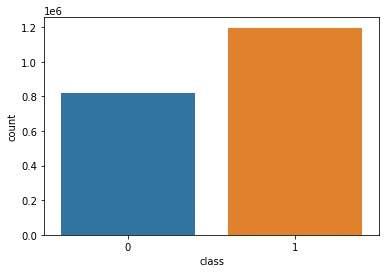

In [17]:
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
### Split negative examples df to train and test
from math import floor
test_sample_factor = 0.33
neg_examples_test = neg_examples_df.sample(floor(test_sample_factor * neg_examples_df.shape[0]))
neg_examples_train = neg_examples_df.drop(neg_examples_test.index)

### Create train and test dataframes
train_df = pd.concat([classification_train_df, neg_examples_train], axis = 0).sample(frac = 1)
test_df = pd.concat([classification_test_df, neg_examples_test], axis = 0).sample(frac = 1)

X_train, y_train, train_pairs = train_df[['features_vector']], train_df[['class']], train_df[['SDID', 'ODID']]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=69)
X_test, y_test, test_pairs = test_df[['features_vector']], test_df[['class']], test_df[['SDID', 'ODID']]
### Create Test Dataframe with positive and negative examples of interactions

print("Shape of X_train: {} ------ Class_0: {} -- Class_1: {}".format(X_train.shape[0],  y_train[(y_train.values==0)].count(), y_train[(y_train.values==1)].count()))
print("Shape of X_test: {}  ------ Class_0: {} -- Class_1: {}".format(X_test.shape[0], y_test[(y_test.values==0)].count(), y_test[(y_test.values==1)].count()))
print("Shape of X_val: {}  ------ Class_0: {}  -- Class_1: {}".format(X_val.shape[0], y_val[(y_val.values==0)].count(), y_val[(y_val.values==1)].count()))

print("Plotting counts for Test Data")
sns.countplot(x = 'class', data=pd.DataFrame(data=y_test, columns=['class']))

<AxesSubplot:xlabel='class', ylabel='count'>

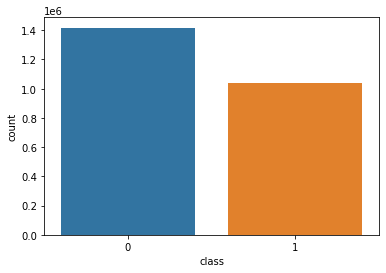

In [14]:
sns.countplot(x = 'class', data=pd.DataFrame(data=y_train, columns=['class']))

<AxesSubplot:xlabel='class', ylabel='count'>

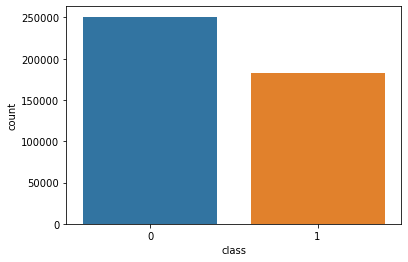

In [15]:
sns.countplot(x = 'class', data=pd.DataFrame(data=y_val, columns=['class']))

In [16]:
## train dataclass TrainData(Dataset):

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train.features_vector.values.tolist()), 
                       torch.FloatTensor(list(map(lambda x: x[0], y_train.values.tolist()))))
## test data    

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test.features_vector.values.tolist()))
val_data = TestData(torch.FloatTensor(X_val.features_vector.values.tolist()))

C:\Users\user\AppData\Local\Temp/ipykernel_10032/4006307011.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_data = TrainData(torch.FloatTensor(X_train.features_vector.values.tolist()),


In [17]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 256.
        self.layer_1 = nn.Linear(256, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")
print(device)


# Define Model
model = BinaryClassification()
model.cuda()
model.to(device)
print(model)

cuda
BinaryClassification(
  (layer_1): Linear(in_features=256, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [18]:
from sklearn.metrics import accuracy_score
### Train the model
# Model Parameters
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EARLY_STOPPING = 3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
bad_progress_counter = 0
model_epoch = 0
best_val_acc = 0

# Create Loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader = DataLoader(dataset=val_data, batch_size=1)

print(device)
model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()        
        y_pred = model(X_batch.cuda()).to(device)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1)).to(device)
        acc = binary_acc(y_pred, y_batch.unsqueeze(1)).to(device)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # validation
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            y_val_pred = model(X_batch)
            y_val_pred = torch.sigmoid(y_val_pred)
            y_pred_tag = torch.round(y_val_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    val_acc = accuracy_score(y_pred_list, y_val)
    if e==1: 
        best_val_acc = val_acc
    elif best_val_acc <= val_acc:
        bad_progress_counter = 0
    else:
        bad_progress_counter +=1
    
    if bad_progress_counter == EARLY_STOPPING:
        print("Applying Early Stop")
        break
    # End of validation step

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val Acc: {val_acc}')
    if(val_acc > best_val_acc):
        node2vec = model   #Store model
        model_epoch = e
        best_val_acc = val_acc
    
print("Keeping model from epoch: {}".format(model_epoch))

cuda
Epoch 001: | Loss: 0.33719 | Acc: 85.125 | Val Acc: 0.8745634384774303
Epoch 002: | Loss: 0.26042 | Acc: 88.731 | Val Acc: 0.8924783306210542
Epoch 003: | Loss: 0.22988 | Acc: 90.094 | Val Acc: 0.9001742783606292
Epoch 004: | Loss: 0.20908 | Acc: 91.002 | Val Acc: 0.907306995371813
Epoch 005: | Loss: 0.19329 | Acc: 91.714 | Val Acc: 0.9104393892178249
Epoch 006: | Loss: 0.18079 | Acc: 92.280 | Val Acc: 0.9147421026511086
Epoch 007: | Loss: 0.17024 | Acc: 92.743 | Val Acc: 0.9178283300439736
Epoch 008: | Loss: 0.16114 | Acc: 93.169 | Val Acc: 0.9200235448911048
Epoch 009: | Loss: 0.15350 | Acc: 93.489 | Val Acc: 0.9232621215793544
Epoch 010: | Loss: 0.14676 | Acc: 93.782 | Val Acc: 0.9251664877716608
Epoch 011: | Loss: 0.14051 | Acc: 94.059 | Val Acc: 0.9260390337361356
Epoch 012: | Loss: 0.13499 | Acc: 94.304 | Val Acc: 0.927544060108722
Epoch 013: | Loss: 0.13014 | Acc: 94.528 | Val Acc: 0.9287536211811687
Epoch 014: | Loss: 0.12554 | Acc: 94.703 | Val Acc: 0.9284050644599102
Epo

In [19]:
### Test the model
y_pred_list = []
node2vec.eval()
with torch.no_grad():
    for X_batch in tqdm(test_loader, total = len(test_loader)):
        X_batch = X_batch.to(device)
        y_test_pred = node2vec(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(y_test, y_pred_list))

100%|██████████| 2017580/2017580 [36:54<00:00, 911.00it/s] 


              precision    recall  f1-score   support

           0       0.90      0.94      0.92    821623
           1       0.96      0.93      0.94   1195957

    accuracy                           0.93   2017580
   macro avg       0.93      0.94      0.93   2017580
weighted avg       0.93      0.93      0.93   2017580



<AxesSubplot:>

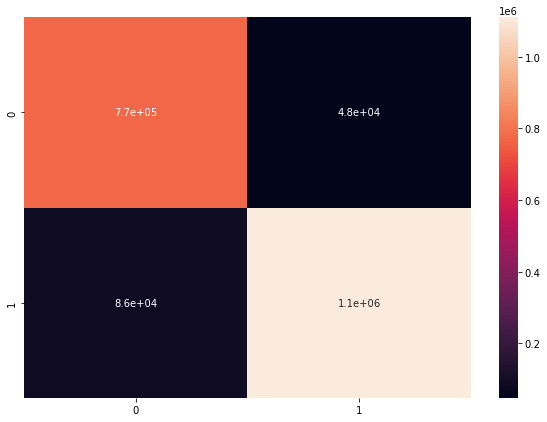

In [20]:
cm=confusion_matrix(y_test, y_pred_list)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [32]:
### SAVE Result Data
# with open('drugbank_experiment_pickles/node2vec_large_full_results.pickle', 'wb') as handle:
#     pickle.dump((test_pairs, y_test, y_pred_list), handle, protocol=pickle.HIGHEST_PROTOCOL)

### LOAD Data from Pickles --- folder: drugbank_experiment_pickless
with open('drugbank_experiment_pickles/node2vec_large_full_results.pickle', 'rb') as handle:
    test_pairs_n, y_test_n, y_pred_list_n = pickle.load(handle)
test_pairs, y_test, y_pred_list = test_pairs_n, y_test_n, y_pred_list_n

In [33]:
from statistics import mean
###### Compute Useful Test Results regadring Graph Properites on the Test Set's Nodes
# test_pairs, degreeNodes, y_test, y_pred
correct_degrees, min_correct_degrees, max_correct_degrees = [], [], []
false_degrees, min_false_degrees, max_false_degrees = [], [], []
correct_core_diffs, false_core_diffs = [], []
correct_b_centrality, false_b_centrality = [], []
pairs = test_pairs.values
test_values = y_test.values
for i in range(len(pairs)):
    scid, ocid = pairs[i][0], pairs[i][1]
    sdegree, odegree = degreeNodes[scid], degreeNodes[ocid]
    score, ocore = core_dict[scid], core_dict[ocid]
    if int(test_values[i][0]) == int(y_pred_list[i]):   # Correct decision for NN
        correct_degrees.append(1.0*(sdegree + odegree)/2)
        min_correct_degrees.append(min(sdegree, odegree))
        max_correct_degrees.append(max(sdegree, odegree))
        correct_core_diffs.append(abs(score-ocore))
        try: # will only work if edge really exists 
            correct_b_centrality.append(edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)])
        except:
            continue
    else:
        false_degrees.append(1.0*(sdegree + odegree)/2)
        min_false_degrees.append(min(sdegree, odegree))
        max_false_degrees.append(max(sdegree, odegree))
        false_core_diffs.append(abs(score-ocore))
        try: # will only work if edge really exists 
            false_b_centrality.append(edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)])
        except:
            continue

print("Mean Correct Degrees: {}".format(mean(correct_degrees)))
print("Mean MIN Correct Degrees: {}".format(mean(min_correct_degrees)))
print("Mean MAX Correct Degrees: {}".format(mean(max_correct_degrees)))
print("Mean Correct Core Differences: {}".format(mean(correct_core_diffs)))
print("Mean Correct Betweenus Centrality: {}".format(mean(correct_b_centrality)))
print("Mean False Degrees: {}".format(mean(false_degrees)))
print("Mean MIN False Degrees: {}".format(mean(min_false_degrees)))
print("Mean MAX False Degrees: {}".format(mean(max_false_degrees)))
print("Mean False Core Differences: {}".format(mean(false_core_diffs)))
print("Mean False Betweenus Centrality: {}".format(mean(false_b_centrality)))

Mean Correct Degrees: 868.7135665322955
Mean MIN Correct Degrees: 593.4589506312083
Mean MAX Correct Degrees: 1143.9681824333827
Mean Correct Core Differences: 196.0109416507217
Mean Correct Betweenus Centrality: 1.2909670129892695e-06
Mean False Degrees: 806.5886362785124
Mean MIN False Degrees: 470.07917150455074
Mean MAX False Degrees: 1143.0981010524738
Mean False Core Differences: 266.1020113112851
Mean False Betweenus Centrality: 6.994947537197992e-06


In [34]:
### Prepare for Plots
resolution = 1000
b_centrality_limit = 3
distribution_dict = {}
for i in tqdm(range(len(pairs))):
   scid, ocid = pairs[i][0], pairs[i][1]
   sdegree, odegree = degreeNodes[scid], degreeNodes[ocid]
   score, ocore = core_dict[scid], core_dict[ocid]
   is_positive =  int(test_values[i])
   correctly_identified = int(test_values[i]) == int(y_pred_list[i])
   mean_degree = 1.0*(sdegree + odegree)/2
   min_degree = min(sdegree, odegree)
   max_degree = max(sdegree, odegree)
   core_diff = abs(score-ocore)
   try:
      b_centrallity = 10**6*edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)]
   except: 
      b_centrallity = None
   distribution_dict[(scid, ocid)] = [is_positive, correctly_identified, mean_degree, min_degree, max_degree, core_diff, b_centrallity]

distribution_df = pd.DataFrame.from_dict(data = distribution_dict, orient = 'index' , columns= ['is_positive', 'correctly_identified', 'mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality'])


100%|██████████| 2017580/2017580 [00:19<00:00, 101091.62it/s]


In [20]:
### Define parameters for results plots file save
resultsPath = "result_plots/large_drugbank_results/graph2vec/train_with_01_percent/"   ### CHANGE THIS FOR EVERY EXPERIMENT
metrics_dict = {"mean_degree":"Mean Degree", "min_degree":"Min Degree", "max_degree":"Max Degree", "core_diff":"Core Difference", "b_centrality":"Betweenness Centrality"}

### Plot Group A: Histogram grouped by categories in same plot
for x_axis_variable in ['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']:

    x1 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)]
    x2 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)]
    x3 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)]
    x4 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)]

    kwargs = dict(alpha=0.5, bins=100, density=False, stacked=True)
    if x_axis_variable != "b_centrality":
        plt.hist(x1, **kwargs, color='g', label='Negative Correctly Identified')
        plt.hist(x2, **kwargs, color='b', label='Negative Incorrectly Identified')
    else:
        x3 = x3[x3.between(0,b_centrality_limit)]
        x4 = x4[x4.between(0,b_centrality_limit)]
    plt.hist(x3, **kwargs, color='r', label='Positive Correctly Identified')
    plt.hist(x4, **kwargs, color='c', label='Positive Incorrectly Identified')
    plt.gca().set(title="Frequency Histogram of Classifier's predictions", ylabel='Frequency', xlabel = metrics_dict[x_axis_variable])
    # plt.xlim(50,75)
    plt.legend()
    imageName = "groupA_Frequency Histogram of Classifier's predictions_" + x_axis_variable
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

### Plot Group AX: Density grouped by categories in same plot
for x_axis_variable in ['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']:

    x1 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)]
    x2 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)]
    x3 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)]
    x4 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)]

    # Normalize
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
    if x_axis_variable != "b_centrality":
        plt.hist(x1, **kwargs, color='g', label='Negative Correctly Identified')
        plt.hist(x2, **kwargs, color='b', label='Negative Incorrectly Identified')
    else:
        x3 = x3[x3.between(0,b_centrality_limit)]
        x4 = x4[x4.between(0,b_centrality_limit)]
    plt.hist(x3, **kwargs, color='r', label='Positive Correctly Identified')
    plt.hist(x4, **kwargs, color='c', label='Positive Incorrectly Identified')
    plt.gca().set(title="Density Histogram of Classifier's predictions", ylabel='Density', xlabel = metrics_dict[x_axis_variable])
    # plt.xlim(50,75)
    plt.legend()
    imageName = "groupAX_Density Histogram of Classifier's predictions_" + x_axis_variable
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

   
### Plot Group B: Density grouped by categories in separate subplots

param_list = []
for pos in [0,1]:
    for corr in [True, False]:
        param_list.append((distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr))
titles = ['Negative Correctly Identified', 'Negative Incorrectly Identified', 'Positive Correctly Identified', 'Positive Incorrectly Identified']
colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:cyan']
for selector in ['mean_degree', 'min_degree', 'max_degree', 'core_diff']:
    fig, axes = plt.subplots(1, 4, figsize=(15,2.5), dpi=resolution, sharex=True, sharey=True)
    for i, (ax, param) in enumerate(zip(axes.flatten(), param_list)):
        x = distribution_df[selector][param]
        ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(titles[i]), color=colors[i])
        ax.set_title(titles[i])
        ax.set_ylabel = "Density"
        ax.set_xlabel = selector
    plt.suptitle('Classifier Predictions: Density of {}'.format(metrics_dict[selector]), y=1)
    plt.tight_layout()
    imageName = "groupB_Density Histogram of Classifier's predictions_" + selector
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

############# Repeat for Distributions that recognize only positive edges
param_list = []
for pos in [1]:
    for corr in [True, False]:
        param_list.append((distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr))
titles = ['Positive Correctly Identified', 'Positive Incorrectly Identified']

for selector in ['b_centrality']:
    fig, axes = plt.subplots(1, 2, figsize=(15,2.5), dpi=resolution, sharex=True, sharey=True)
    for i, (ax, param) in enumerate(zip(axes.flatten(), param_list)):
        x = distribution_df[selector][param]
        x = x[x.between(0,b_centrality_limit)]

        ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(titles[i]), color=colors[i])
        ax.set_title(titles[i])
        ax.set_ylabel = "Density"
        ax.set_xlabel = selector
    plt.suptitle('Classifier Predictions: Density of {}'.format(metrics_dict[selector]), y=1)
    plt.tight_layout()
    imageName = "groupB_Density Histogram of Classifier's predictions_" + selector
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

### Plot Group C: KDE 
titles = ['Negative Correctly Identified', 'Negative Incorrectly Identified', 'Positive Correctly Identified', 'Positive Incorrectly Identified']

for selector in ['mean_degree', 'min_degree', 'max_degree', 'core_diff']:
    dv_list = []
    i=0
    for pos in [0,1]:
        for corr in [True, False]:
            dv = distribution_df[selector][(distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr)].value_counts()
            #dv = dv/dv.sum()
            dv = dv.rename(titles[i]+ " -  " + selector)
            i += 1
            dv = dv.sort_index()
            dv_list.append(dv)

    dist_df = pd.concat(dv_list, axis=1)
    dist_df = pd.concat(dv_list, axis=1).fillna(0)
    kwargs = dict(title="Kernel Density Estimate for Classifier's Predictions: {}".format(metrics_dict[selector]), color=colors)
    figSrc = dist_df.plot.kde(**kwargs, bw_method=0.03)
    fig = figSrc.get_figure()
    imageName = "groupC_KDE of Classifier's predictions_" + selector
    fig.savefig(resultsPath + imageName + ".png", dpi=resolution, bbox_inches='tight')
    plt.close(fig)
    
    
    

############# Repeat for Distributions that recognize only positive edges
for selector in ['b_centrality']:
    dv_list = []
    i=2
    for pos in [1]:
        for corr in [True, False]:
            x = distribution_df[selector][(distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr)]
            x = x[x.between(0,b_centrality_limit)]
            dv = x.value_counts()
            #dv = dv/dv.sum()
            dv = dv.rename(titles[i]+ " -  " + selector)
            i += 1
            dv = dv.sort_index()
            dv_list.append(dv)
    dist_df = pd.concat(dv_list, axis=1)
    dist_df = pd.concat(dv_list, axis=1).fillna(0)
    kwargs = dict(title="Kernel Density Estimate for Classifier's Predictions: {}".format(metrics_dict[selector]), color=colors)
    figSrc = dist_df.plot.kde(**kwargs)
    fig = figSrc.get_figure()
    imageName = "groupC_KDE of Classifier's predictions_" + selector
    fig.savefig(resultsPath + imageName + ".png", dpi=resolution, bbox_inches='tight')
    plt.close(fig)

### Compute Stats
print("Total Negative Correctly Identified Samples:     {}".format(distribution_df[(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)].shape[0]))
print("Total Negative Incorrectly Identified Samples:   {}".format(distribution_df[(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)].shape[0]))
print("Total Positive Correctly Identified Samples:     {}".format(distribution_df[(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)].shape[0]))
print("Total Positive Incorrectly Identified Samples:   {}".format(distribution_df[(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)].shape[0]))

#### B-centrality-stats
print("\nB centrality plots where limited on samples with b_centrality < {}".format(b_centrality_limit))
print("Total nodes with b_centrality <  {}:   {}".format(b_centrality_limit, distribution_df[(distribution_df.b_centrality < b_centrality_limit)].shape[0]))
print("Total nodes with b_centrality >= {}:   {}".format(b_centrality_limit, distribution_df[(distribution_df.b_centrality >= b_centrality_limit)].shape[0]))


print("\nKL Divergence Results")
### KL Divergence Computation
print("KL Divergence between distributions from Classifier choices")
kl_list = []
for index, selector in enumerate(['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']):
    print("---" + selector + " ~ KL(Correct | False): {}"\
        .format(KL(distribution_df[distribution_df.correctly_identified==True][selector], distribution_df[distribution_df.correctly_identified==False][selector])))
    print("---" + selector + " ~ KL(False | Correct): {}"\
        .format(KL(distribution_df[distribution_df.correctly_identified==False][selector], distribution_df[distribution_df.correctly_identified==True][selector])))

####### Evaluate Model's Predictions on Drug Groups
distribution_df['sgroup'] = distribution_df.index.map(lambda x: groups_dict[x[0]])
distribution_df['ogroup'] =distribution_df.index.map(lambda x: groups_dict[x[1]])

# Print (ordered) Accuracy and total samples for each category (when at least one drug on the interaction belongs to a category)
group_names = ['approved', 'investigational', 'experimental', 'illicit', 'vet_approved', 'withdrawn', 'nutraceutical']

for name in group_names:
    temp_df = distribution_df[(distribution_df.sgroup==name) | (distribution_df.ogroup==name)]
    accuracy = temp_df[temp_df.correctly_identified==True].shape[0] / temp_df.shape[0]
    neg_samples = temp_df[((temp_df.sgroup==name) | (temp_df.ogroup==name)) & (temp_df.is_positive==0)].shape[0]
    positive_samples = temp_df[((temp_df.sgroup==name) | (temp_df.ogroup==name)) & (temp_df.is_positive==1)].shape[0]
    neg_acc =  temp_df[(temp_df.correctly_identified==True) & (temp_df.is_positive==0)].shape[0] / neg_samples
    pos_acc =  temp_df[(temp_df.correctly_identified==True) & (temp_df.is_positive==1)].shape[0] / positive_samples
    print("Total {} Drugs in Test Samples:  {} --- Model Accuracy {}".format(name, temp_df.shape[0], accuracy))
    print("\t\t{} Drugs in Positive Interactions: {}    Accuracy:{}".format(name, positive_samples, pos_acc))
    print("\t\t{} Drugs in Negative Interactions: {}    Accuracy:{}".format(name, neg_samples, neg_acc))

100%|██████████| 2017580/2017580 [00:18<00:00, 111205.41it/s]


Total Negative Correctly Identified Samples:     773654
Total Negative Incorrectly Identified Samples:   47969
Total Positive Correctly Identified Samples:     1110431
Total Positive Incorrectly Identified Samples:   85526

B centrality plots where limited on samples with b_centrality < 3
Total nodes with b_centrality <  3:   1153662
Total nodes with b_centrality >= 3:   42295

KL Divergence Results
KL Divergence between distributions from Classifier choices
---mean_degree ~ KL(Correct | False): 0.23843751867273796
---mean_degree ~ KL(False | Correct): 0.15878694969134272
---min_degree ~ KL(Correct | False): 0.6118667800059967
---min_degree ~ KL(False | Correct): 0.44105671561530124
---max_degree ~ KL(Correct | False): 0.28767271053982685
---max_degree ~ KL(False | Correct): 0.1988213738031716
---core_diff ~ KL(Correct | False): 0.6153763566490409
---core_diff ~ KL(False | Correct): 0.3688756818717805
---b_centrality ~ KL(Correct | False): 0.366090784329807
---b_centrality ~ KL(False |

In [36]:
#### Model Accuracy for pairs with min_degree < N
N = distribution_df.max_degree.max()
print("Node2Vec Experiment Max Degree: {}".format(N))
node2vec_min_degree_recall_list = []
node2vec_min_degree_accuracy_list = []
for n in tqdm(range(1,N+1)):
    lddf = distribution_df[distribution_df.min_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    node2vec_min_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    node2vec_min_degree_accuracy_list.append(100.0*correct/(correct + false))

node2vec_mean_degree_recall_list = []
node2vec_mean_degree_accuracy_list = []
for n in tqdm(range(6,N+1)):
    lddf = distribution_df[distribution_df.mean_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    node2vec_mean_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    node2vec_mean_degree_accuracy_list.append(100.0*correct/(correct + false))

node2vec_max_degree_recall_list = []
node2vec_max_degree_accuracy_list = []
for n in tqdm(range(11,N+1)):
    lddf = distribution_df[distribution_df.max_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    node2vec_max_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    node2vec_max_degree_accuracy_list.append(100.0*correct/(correct + false))

C = distribution_df.core_diff.max()
node2vec_core_diff_recall_list = []
node2vec_core_diff_accuracy_list = []
print("Node2Vec Experiment Max Core Difference: {}".format(C))
for c in tqdm(range(0,C+1)):
    lddf = distribution_df[distribution_df.core_diff <= c] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    node2vec_core_diff_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    node2vec_core_diff_accuracy_list.append(100.0*correct/(correct + false))

B = distribution_df.b_centrality.max()
node2vec_b_centrality_recall_list = []
node2vec_b_centrality_accuracy_list = []
print("Node2Vec Experiment B Centrality Max: {}".format(B))
for c in tqdm(np.arange(0.01,B+0.1, 0.1)):
    lddf = distribution_df[distribution_df.b_centrality <= c] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    node2vec_b_centrality_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    node2vec_b_centrality_accuracy_list.append(100.0*correct/(correct + false))

Node2Vec Experiment B Centrality Max: 1766.5901577324814


100%|██████████| 9501/9501 [1:49:02<00:00,  1.45it/s]


In [25]:
### Save node2vec distribution_df
n2v_distribution_df = distribution_df

In [23]:
#### Cross-Experiment KL Divergence
print("\nCross-Experiment KL Divergence Results")
### KL Divergence Computation
print("KL Divergence between distributions from Classifier choices")
kl_list = []
for index, selector in enumerate(['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']):
    print("---" + selector + " ~ KL(N2V Correct | M2V Corrent): {}"\
        .format(KL(n2v_distribution_df[n2v_distribution_df.correctly_identified==True][selector], m2v_distribution_df[m2v_distribution_df.correctly_identified==True][selector])))
    print("---" + selector + " ~ KL(M2V Correct | N2V Corrent): {}"\
        .format(KL(m2v_distribution_df[m2v_distribution_df.correctly_identified==True][selector], n2v_distribution_df[n2v_distribution_df.correctly_identified==True][selector])))
    print("---" + selector + " ~ KL(N2V False | M2V False): {}"\
        .format(KL(n2v_distribution_df[n2v_distribution_df.correctly_identified==False][selector], m2v_distribution_df[m2v_distribution_df.correctly_identified==False][selector])))
    print("---" + selector + " ~ KL(M2V False | N2V False): {}\n"\
        .format(KL(m2v_distribution_df[m2v_distribution_df.correctly_identified==False][selector], n2v_distribution_df[n2v_distribution_df.correctly_identified==False][selector])))


Cross-Experiment KL Divergence Results
KL Divergence between distributions from Classifier choices
---mean_degree ~ KL(N2V Correct | M2V Corrent): 0.017632281614255466
---mean_degree ~ KL(M2V Correct | N2V Corrent): 0.018012517164554792
---mean_degree ~ KL(N2V False | M2V False): 0.052268235303395326
---mean_degree ~ KL(M2V False | N2V False): 0.04741029338167039

---min_degree ~ KL(N2V Correct | M2V Corrent): 0.0188604312747472
---min_degree ~ KL(M2V Correct | N2V Corrent): 0.019228732610609853
---min_degree ~ KL(N2V False | M2V False): 0.1591666991328424
---min_degree ~ KL(M2V False | N2V False): 0.1997241594641146

---max_degree ~ KL(N2V Correct | M2V Corrent): 0.009616856999478424
---max_degree ~ KL(M2V Correct | N2V Corrent): 0.010039933457282622
---max_degree ~ KL(N2V False | M2V False): 0.09293503693410834
---max_degree ~ KL(M2V False | N2V False): 0.11099922255014526

---core_diff ~ KL(N2V Correct | M2V Corrent): 0.013483585587077795
---core_diff ~ KL(M2V Correct | N2V Corrent

In [ ]:
############################### Hybrid Model Experiment ################################################

In [14]:
structures_df = structures_df.dropna(subset = ['node2vec', 'mol2vec'])
structures_df['mixedvec'] = structures_df.apply(lambda x: np.concatenate((x.node2vec, x.mol2vec.vec)), axis=1)

In [15]:
from tqdm import tqdm
from random import random
#### Create Classification Dataframe with true samples {features_vector, 1} ####
classification_train_rows_list = []
classification_test_rows_list = []
MOVE_TO_TRAIN_PROB = 0.70
mv_dict = dict(zip(structures_df.DATABASE_ID, structures_df.mixedvec))

for index, row in tqdm(valid_interactions.iterrows(), total=valid_interactions.shape[0]):
    s_mv = mv_dict[row['SDID']]
    scid = row['SDID']
    o_mv = mv_dict[row['ODID']]
    ocid = row['ODID']
    is_test = (row['SDID'],row['ODID']) in removed_set or (row['ODID'], row['SDID']) in removed_set
    try:   
        fv_direct = np.concatenate((s_mv, o_mv))
        if is_test and (random() > MOVE_TO_TRAIN_PROB): # with prob to move to train
            # fv_opposite = np.concatenate((o_node2vec, s_node2vec)) ### track opposite direction of interacts relationship
            classification_test_rows_list.append([fv_direct, 1, scid, ocid])
            # classification_test_rows_list.append([fv_opposite, 1])  ### opposite is not needed since neo4j contains reverse of each edge
        else:
            classification_train_rows_list.append([fv_direct, 1, scid, ocid])
    except IndexError:
        print("IndexError on index: {} for subject: {} and object: {}".format(index, scid, ocid))

    
classification_train_df = pd.DataFrame(data = classification_train_rows_list, columns=['features_vector', 'class', 'SDID', 'ODID']) 
classification_test_df = pd.DataFrame(data = classification_test_rows_list, columns=['features_vector', 'class', 'SDID', 'ODID']) 
# Remove duplicates
#classification_df = classification_df[~classification_df['features_vector'].apply(tuple).duplicated()]
print("Classification Train DF shape:{}".format(classification_train_df.shape))
print("Classification Test DF shape:{}".format(classification_test_df.shape))

100%|██████████| 2415906/2415906 [03:45<00:00, 10727.56it/s]


Classification Train DF shape:(1699053, 4)
Classification Test DF shape:(716853, 4)


In [16]:
from random import randrange, choice
# Add samples with substances that do not interact
# Generate random tuples from the substances list, and if they do not appear on the interactions_df add them as a non interaction

def getSetWithAllPairs(df, col1, col2):
    return set(list(zip(df[col1],df[col2])))
 
def getNegSamples(pairs_to_avoid, substances_df, neg_sample_size, result_list, result_idx, bad_cids):
    subs_cid_list = list(set().union(valid_interactions['SDID'].unique(), valid_interactions['ODID'].unique()))
    neg_examples = []
    while len(neg_examples) < neg_sample_size:
        # Generate random pair
        cid_a = choice(subs_cid_list)
        cid_b = choice(subs_cid_list)
        if((cid_a in bad_cids) or (cid_b in bad_cids)):
            continue
        # flag1 = not phsu_interacts_df.loc[(phsu_interacts_df['snode_cid'] == cid_a) & (phsu_interacts_df['onode_cid'] == cid_b)].any().all()
        # flag2 = not phsu_interacts_df.loc[(phsu_interacts_df['snode_cid'] == cid_b) & (phsu_interacts_df['onode_cid'] == cid_a)].any().all()
        flag1 = (cid_a, cid_b) not in pairs_to_avoid
        flag2 = (cid_b, cid_a) not in pairs_to_avoid
        if(cid_a != cid_b and flag1 and flag2):
            #s_mv = structures_df[structures_df.DATABASE_ID == row[cid_a]].mixedvec
            #o_mv = structures_df[structures_df.DATABASE_ID == row[cid_b]].mixedvec
            try:   
                # fv_direct = np.concatenate((s_mv.tolist(), o_mv.tolist()))
                # fv_opposite = np.concatenate((o_mv.tolist(), s_mv.tolist())) ### track opposite direction of interacts relationship
                neg_examples.append([0, cid_a, cid_b])
                neg_examples.append([0, cid_b, cid_a])
            except IndexError:
                print("IndexError on index: {} for subject: {} and object: {}".format(index, cid_a, cid_b))
    result_list[result_idx-1] = neg_examples
    return

thread_list = []
NEG_SAMPLE_SIZE = 700000 # For each thread
THREADS = 4
result_list = [None]*THREADS
pairs_2_avoid = getSetWithAllPairs(valid_interactions, 'SDID', 'ODID')
bad_cids = {2122, 6227}
print("Initiating Multithreading Execution")
for i in range(THREADS):
    thread = Thread(target = getNegSamples, args = [pairs_2_avoid,valid_interactions, NEG_SAMPLE_SIZE, result_list, i, bad_cids])
    thread_list.append(thread)
    thread.start()

for t in thread_list:
    t.join()

print("Exited Multithreaded Section")

neg_examples = []
for l in result_list:
    if l != None: neg_examples.extend(l)
            
print("Creating Dataframe with negative samples")
neg_examples_df = pd.DataFrame(data = neg_examples, columns=['class', 'SDID', 'ODID'])
print("Removing Duplicate vectors") 
#Remove duplicates
# neg_examples_df = neg_examples_df[~neg_examples_df['features_vector'].apply(str).duplicated()] 
neg_examples_df = neg_examples_df.drop_duplicates()

# Create features_vector column
neg_examples_df["features_vector"] = neg_examples_df.apply(lambda r: np.concatenate((mv_dict[r.SDID], mv_dict[r.ODID])), axis = 1)

Initiating Multithreading Execution
Exited Multithreaded Section
Creating Dataframe with negative samples
Removing Duplicate vectors


Shape of X_train: 2862074 ------ Class_0: class    1417479
dtype: int64 -- Class_1: class    1444595
dtype: int64
Shape of X_test: 1538451  ------ Class_0: class    821598
dtype: int64 -- Class_1: class    716853
dtype: int64
Shape of X_val: 505073  ------ Class_0: class    250615
dtype: int64  -- Class_1: class    254458
dtype: int64
Plotting counts for Test Data


<AxesSubplot:xlabel='class', ylabel='count'>

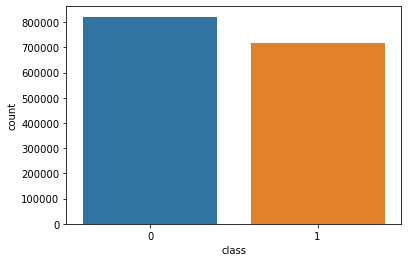

In [17]:
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
### Split negative examples df to train and test
from math import floor
test_sample_factor = 0.33
neg_examples_test = neg_examples_df.sample(floor(test_sample_factor * neg_examples_df.shape[0]))
neg_examples_train = neg_examples_df.drop(neg_examples_test.index)

### Create train and test dataframes
train_df = pd.concat([classification_train_df, neg_examples_train], axis = 0).sample(frac = 1)
test_df = pd.concat([classification_test_df, neg_examples_test], axis = 0).sample(frac = 1)

X_train, y_train, train_pairs = train_df[['features_vector']], train_df[['class']], train_df[['SDID', 'ODID']]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=69)
X_test, y_test, test_pairs = test_df[['features_vector']], test_df[['class']], test_df[['SDID', 'ODID']]
### Create Test Dataframe with positive and negative examples of interactions

print("Shape of X_train: {} ------ Class_0: {} -- Class_1: {}".format(X_train.shape[0],  y_train[(y_train.values==0)].count(), y_train[(y_train.values==1)].count()))
print("Shape of X_test: {}  ------ Class_0: {} -- Class_1: {}".format(X_test.shape[0], y_test[(y_test.values==0)].count(), y_test[(y_test.values==1)].count()))
print("Shape of X_val: {}  ------ Class_0: {}  -- Class_1: {}".format(X_val.shape[0], y_val[(y_val.values==0)].count(), y_val[(y_val.values==1)].count()))

print("Plotting counts for Test Data")
sns.countplot(x = 'class', data=pd.DataFrame(data=y_test, columns=['class']))

<AxesSubplot:xlabel='class', ylabel='count'>

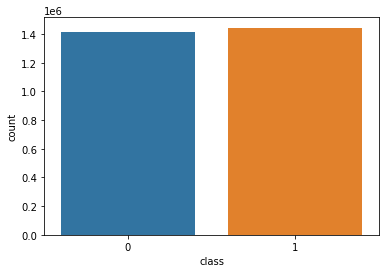

In [18]:
sns.countplot(x = 'class', data=pd.DataFrame(data=y_train, columns=['class']))

<AxesSubplot:xlabel='class', ylabel='count'>

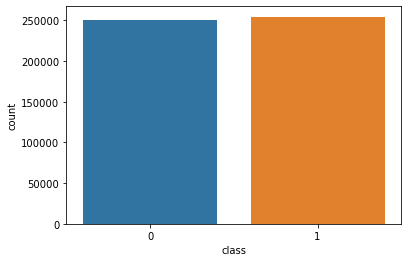

In [19]:
sns.countplot(x = 'class', data=pd.DataFrame(data=y_val, columns=['class']))

In [20]:
## train dataclass TrainData(Dataset):

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train.features_vector.values.tolist()), 
                       torch.FloatTensor(list(map(lambda x: x[0], y_train.values.tolist()))))
## test data    

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test.features_vector.values.tolist()))
val_data = TestData(torch.FloatTensor(X_val.features_vector.values.tolist()))

C:\Users\user\AppData\Local\Temp/ipykernel_7020/4006307011.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_data = TrainData(torch.FloatTensor(X_train.features_vector.values.tolist()),


In [21]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 256.
        self.layer_1 = nn.Linear(856, 2048)
        self.layer_2 = nn.Linear(2048, 1024)
        self.layer_3 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")
print(device)


# Define Model
model = BinaryClassification()
model.cuda()
model.to(device)
print(model)

cuda
BinaryClassification(
  (layer_1): Linear(in_features=856, out_features=2048, bias=True)
  (layer_2): Linear(in_features=2048, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [22]:
from sklearn.metrics import accuracy_score
### Train the model
# Model Parameters
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EARLY_STOPPING = 5

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
bad_progress_counter = 0
model_epoch = 0
best_val_acc = 0

# Create Loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader = DataLoader(dataset=val_data, batch_size=1)

print(device)
model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()        
        y_pred = model(X_batch.cuda()).to(device)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1)).to(device)
        acc = binary_acc(y_pred, y_batch.unsqueeze(1)).to(device)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # validation
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            y_val_pred = model(X_batch)
            y_val_pred = torch.sigmoid(y_val_pred)
            y_pred_tag = torch.round(y_val_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    val_acc = accuracy_score(y_pred_list, y_val)
    if e==1: 
        best_val_acc = val_acc
    elif best_val_acc <= val_acc:
        bad_progress_counter = 0
    else:
        bad_progress_counter +=1
    
    if bad_progress_counter == EARLY_STOPPING:
        print("Applying Early Stop")
        break
    # End of validation step

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val Acc: {val_acc}')
    if(val_acc > best_val_acc):
        hybrid = model   #Store model
        model_epoch = e
        best_val_acc = val_acc
    
print("Keeping model from epoch: {}".format(model_epoch))

cuda
Epoch 001: | Loss: 0.39186 | Acc: 81.967 | Val Acc: 0.8323133487634461
Epoch 002: | Loss: 0.55015 | Acc: 82.159 | Val Acc: 0.8468617407780658
Epoch 003: | Loss: 0.32247 | Acc: 85.641 | Val Acc: 0.8599073797253071
Epoch 004: | Loss: 0.28707 | Acc: 87.320 | Val Acc: 0.8781542470098381
Epoch 005: | Loss: 0.25980 | Acc: 88.646 | Val Acc: 0.8881805204396196
Epoch 006: | Loss: 0.23868 | Acc: 89.670 | Val Acc: 0.891647346027208
Epoch 007: | Loss: 0.22384 | Acc: 90.432 | Val Acc: 0.9045524112356036
Epoch 008: | Loss: 0.23187 | Acc: 90.930 | Val Acc: 0.9072292520091155
Epoch 009: | Loss: 0.19978 | Acc: 91.502 | Val Acc: 0.9109138678963239
Epoch 010: | Loss: 0.18985 | Acc: 91.955 | Val Acc: 0.913465974225508
Epoch 011: | Loss: 0.25467 | Acc: 92.403 | Val Acc: 0.9184474323513631
Epoch 012: | Loss: 0.19377 | Acc: 92.763 | Val Acc: 0.9185602873248025
Epoch 013: | Loss: 0.17671 | Acc: 92.824 | Val Acc: 0.9233892922409236
Epoch 014: | Loss: 0.16050 | Acc: 93.278 | Val Acc: 0.9245119022398742
Epo

In [29]:
model_epoch

49

In [33]:
########### Extra Training
print(device)

for e in range(51, 80):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()        
        y_pred = model(X_batch.cuda()).to(device)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1)).to(device)
        acc = binary_acc(y_pred, y_batch.unsqueeze(1)).to(device)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # validation
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            y_val_pred = model(X_batch)
            y_val_pred = torch.sigmoid(y_val_pred)
            y_pred_tag = torch.round(y_val_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    val_acc = accuracy_score(y_pred_list, y_val)
    if e==1: 
        best_val_acc = val_acc
    elif best_val_acc <= val_acc:
        bad_progress_counter = 0
    else:
        bad_progress_counter +=1
    
    if bad_progress_counter == EARLY_STOPPING:
        print("Applying Early Stop")
        break
    # End of validation step

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val Acc: {val_acc}')
    if(val_acc > best_val_acc):
        hybrid = model   #Store model
        model_epoch = e
        best_val_acc = val_acc
    
print("Keeping model from epoch: {}".format(model_epoch))

cuda
Epoch 051: | Loss: 0.34769 | Acc: 84.466 | Val Acc: 0.8733054429755699
Applying Early Stop
Keeping model from epoch: 49


In [23]:
### Test the model
y_pred_list = []
hybrid.eval()
with torch.no_grad():
    for X_batch in tqdm(test_loader, total = len(test_loader)):
        X_batch = X_batch.to(device)
        y_test_pred = hybrid(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(y_test, y_pred_list))

100%|██████████| 1538451/1538451 [28:14<00:00, 908.14it/s] 


              precision    recall  f1-score   support

           0       0.96      0.94      0.95    821598
           1       0.93      0.95      0.94    716853

    accuracy                           0.95   1538451
   macro avg       0.95      0.95      0.95   1538451
weighted avg       0.95      0.95      0.95   1538451



<AxesSubplot:>

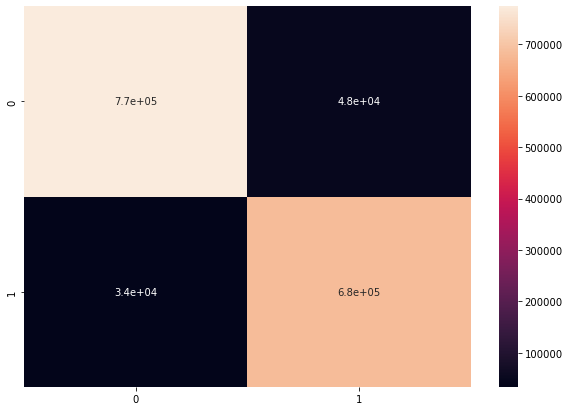

In [24]:
cm=confusion_matrix(y_test, y_pred_list)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [26]:
### SAVE Result Data
# with open('drugbank_experiment_pickles/mixedvec_large_full_results.pickle', 'wb') as handle:
#     pickle.dump((test_pairs, y_test, y_pred_list), handle, protocol=pickle.HIGHEST_PROTOCOL)

### LOAD Data from Pickles --- folder: drugbank_experiment_pickless
with open('drugbank_experiment_pickles/mixedvec_large_full_results.pickle', 'rb') as handle:
    test_pairs_mixed, y_test_mixed, y_pred_list_mixed = pickle.load(handle)
test_pairs, y_test, y_pred_list = test_pairs_mixed, y_test_mixed, y_pred_list_mixed

In [27]:
from statistics import mean
###### Compute Useful Test Results regadring Graph Properites on the Test Set's Nodes
# test_pairs, degreeNodes, y_test, y_pred
correct_degrees, min_correct_degrees, max_correct_degrees = [], [], []
false_degrees, min_false_degrees, max_false_degrees = [], [], []
correct_core_diffs, false_core_diffs = [], []
correct_b_centrality, false_b_centrality = [], []
pairs = test_pairs.values
test_values = y_test.values
for i in range(len(pairs)):
    scid, ocid = pairs[i][0], pairs[i][1]
    sdegree, odegree = degreeNodes[scid], degreeNodes[ocid]
    score, ocore = core_dict[scid], core_dict[ocid]
    if int(test_values[i][0]) == int(y_pred_list[i]):   # Correct decision for NN
        correct_degrees.append(1.0*(sdegree + odegree)/2)
        min_correct_degrees.append(min(sdegree, odegree))
        max_correct_degrees.append(max(sdegree, odegree))
        correct_core_diffs.append(abs(score-ocore))
        try: # will only work if edge really exists 
            correct_b_centrality.append(edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)])
        except:
            continue
    else:
        false_degrees.append(1.0*(sdegree + odegree)/2)
        min_false_degrees.append(min(sdegree, odegree))
        max_false_degrees.append(max(sdegree, odegree))
        false_core_diffs.append(abs(score-ocore))
        try: # will only work if edge really exists 
            false_b_centrality.append(edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)])
        except:
            continue

print("Mean Correct Degrees: {}".format(mean(correct_degrees)))
print("Mean MIN Correct Degrees: {}".format(mean(min_correct_degrees)))
print("Mean MAX Correct Degrees: {}".format(mean(max_correct_degrees)))
print("Mean Correct Core Differences: {}".format(mean(correct_core_diffs)))
print("Mean Correct Betweenus Centrality: {}".format(mean(correct_b_centrality)))
print("Mean False Degrees: {}".format(mean(false_degrees)))
print("Mean MIN False Degrees: {}".format(mean(min_false_degrees)))
print("Mean MAX False Degrees: {}".format(mean(max_false_degrees)))
print("Mean False Core Differences: {}".format(mean(false_core_diffs)))
print("Mean False Betweenus Centrality: {}".format(mean(false_b_centrality)))

Mean Correct Degrees: 795.3818969831738
Mean MIN Correct Degrees: 512.0931479331621
Mean MAX Correct Degrees: 1078.6706460331857
Mean Correct Core Differences: 231.8069864210897
Mean Correct Betweenus Centrality: 1.4445836090574551e-06
Mean False Degrees: 840.2274537591321
Mean MIN False Degrees: 517.010237740367
Mean MAX False Degrees: 1163.4446697778972
Mean False Core Differences: 242.3429520854204
Mean False Betweenus Centrality: 6.762802381509822e-06


In [28]:
### Prepare for Plots
resolution = 1000
b_centrality_limit = 3
distribution_dict = {}
for i in tqdm(range(len(pairs))):
   scid, ocid = pairs[i][0], pairs[i][1]
   sdegree, odegree = degreeNodes[scid], degreeNodes[ocid]
   score, ocore = core_dict[scid], core_dict[ocid]
   is_positive =  int(test_values[i])
   correctly_identified = int(test_values[i]) == int(y_pred_list[i])
   mean_degree = 1.0*(sdegree + odegree)/2
   min_degree = min(sdegree, odegree)
   max_degree = max(sdegree, odegree)
   core_diff = abs(score-ocore)
   try:
      b_centrallity = 10**6*edge_betweeness_centrality[(scid, ocid)] if ((scid, ocid) in edge_betweeness_centrality.keys()) else edge_betweeness_centrality[(ocid, scid)]
   except: 
      b_centrallity = None
   distribution_dict[(scid, ocid)] = [is_positive, correctly_identified, mean_degree, min_degree, max_degree, core_diff, b_centrallity]

distribution_df = pd.DataFrame.from_dict(data = distribution_dict, orient = 'index' , columns= ['is_positive', 'correctly_identified', 'mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality'])

### Save node2vec distribution_df
hybrid_distribution_df = distribution_df

100%|██████████| 1538451/1538451 [00:14<00:00, 105666.33it/s]


In [27]:
### Define parameters for results plots file save
resultsPath = "result_plots/large_drugbank_results/hybrid/"   ### CHANGE THIS FOR EVERY EXPERIMENT
metrics_dict = {"mean_degree":"Mean Degree", "min_degree":"Min Degree", "max_degree":"Max Degree", "core_diff":"Core Difference", "b_centrality":"Betweenness Centrality"}

### Plot Group A: Histogram grouped by categories in same plot
for x_axis_variable in ['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']:

    x1 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)]
    x2 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)]
    x3 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)]
    x4 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)]

    kwargs = dict(alpha=0.5, bins=100, density=False, stacked=True)
    if x_axis_variable != "b_centrality":
        plt.hist(x1, **kwargs, color='g', label='Negative Correctly Identified')
        plt.hist(x2, **kwargs, color='b', label='Negative Incorrectly Identified')
    else:
        x3 = x3[x3.between(0,b_centrality_limit)]
        x4 = x4[x4.between(0,b_centrality_limit)]
    plt.hist(x3, **kwargs, color='r', label='Positive Correctly Identified')
    plt.hist(x4, **kwargs, color='c', label='Positive Incorrectly Identified')
    plt.gca().set(title="Frequency Histogram of Classifier's predictions", ylabel='Frequency', xlabel = metrics_dict[x_axis_variable])
    # plt.xlim(50,75)
    plt.legend()
    imageName = "groupA_Frequency Histogram of Classifier's predictions_" + x_axis_variable
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

### Plot Group AX: Density grouped by categories in same plot
for x_axis_variable in ['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']:

    x1 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)]
    x2 = distribution_df[x_axis_variable][(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)]
    x3 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)]
    x4 = distribution_df[x_axis_variable][(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)]

    # Normalize
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
    if x_axis_variable != "b_centrality":
        plt.hist(x1, **kwargs, color='g', label='Negative Correctly Identified')
        plt.hist(x2, **kwargs, color='b', label='Negative Incorrectly Identified')
    else:
        x3 = x3[x3.between(0,b_centrality_limit)]
        x4 = x4[x4.between(0,b_centrality_limit)]
    plt.hist(x3, **kwargs, color='r', label='Positive Correctly Identified')
    plt.hist(x4, **kwargs, color='c', label='Positive Incorrectly Identified')
    plt.gca().set(title="Density Histogram of Classifier's predictions", ylabel='Density', xlabel = metrics_dict[x_axis_variable])
    # plt.xlim(50,75)
    plt.legend()
    imageName = "groupAX_Density Histogram of Classifier's predictions_" + x_axis_variable
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

   
### Plot Group B: Density grouped by categories in separate subplots

param_list = []
for pos in [0,1]:
    for corr in [True, False]:
        param_list.append((distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr))
titles = ['Negative Correctly Identified', 'Negative Incorrectly Identified', 'Positive Correctly Identified', 'Positive Incorrectly Identified']
colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:cyan']
for selector in ['mean_degree', 'min_degree', 'max_degree', 'core_diff']:
    fig, axes = plt.subplots(1, 4, figsize=(15,2.5), dpi=resolution, sharex=True, sharey=True)
    for i, (ax, param) in enumerate(zip(axes.flatten(), param_list)):
        x = distribution_df[selector][param]
        ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(titles[i]), color=colors[i])
        ax.set_title(titles[i])
        ax.set_ylabel = "Density"
        ax.set_xlabel = selector
    plt.suptitle('Classifier Predictions: Density of {}'.format(metrics_dict[selector]), y=1)
    plt.tight_layout()
    imageName = "groupB_Density Histogram of Classifier's predictions_" + selector
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

############# Repeat for Distributions that recognize only positive edges
param_list = []
for pos in [1]:
    for corr in [True, False]:
        param_list.append((distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr))
titles = ['Positive Correctly Identified', 'Positive Incorrectly Identified']

for selector in ['b_centrality']:
    fig, axes = plt.subplots(1, 2, figsize=(15,2.5), dpi=resolution, sharex=True, sharey=True)
    for i, (ax, param) in enumerate(zip(axes.flatten(), param_list)):
        x = distribution_df[selector][param]
        x = x[x.between(0,b_centrality_limit)]

        ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(titles[i]), color=colors[i])
        ax.set_title(titles[i])
        ax.set_ylabel = "Density"
        ax.set_xlabel = selector
    plt.suptitle('Classifier Predictions: Density of {}'.format(metrics_dict[selector]), y=1)
    plt.tight_layout()
    imageName = "groupB_Density Histogram of Classifier's predictions_" + selector
    plt.savefig(resultsPath + imageName +'.png', dpi=resolution, bbox_inches='tight')
    plt.close()

### Plot Group C: KDE 
titles = ['Negative Correctly Identified', 'Negative Incorrectly Identified', 'Positive Correctly Identified', 'Positive Incorrectly Identified']

for selector in ['mean_degree', 'min_degree', 'max_degree', 'core_diff']:
    dv_list = []
    i=0
    for pos in [0,1]:
        for corr in [True, False]:
            dv = distribution_df[selector][(distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr)].value_counts()
            #dv = dv/dv.sum()
            dv = dv.rename(titles[i]+ " -  " + selector)
            i += 1
            dv = dv.sort_index()
            dv_list.append(dv)

    dist_df = pd.concat(dv_list, axis=1)
    dist_df = pd.concat(dv_list, axis=1).fillna(0)
    kwargs = dict(title="Kernel Density Estimate for Classifier's Predictions: {}".format(metrics_dict[selector]), color=colors)
    figSrc = dist_df.plot.kde(**kwargs, bw_method=0.03)
    fig = figSrc.get_figure()
    imageName = "groupC_KDE of Classifier's predictions_" + selector
    fig.savefig(resultsPath + imageName + ".png", dpi=resolution, bbox_inches='tight')
    plt.close(fig)
    
    
    

############# Repeat for Distributions that recognize only positive edges
for selector in ['b_centrality']:
    dv_list = []
    i=2
    for pos in [1]:
        for corr in [True, False]:
            x = distribution_df[selector][(distribution_df.is_positive==pos) & (distribution_df.correctly_identified==corr)]
            x = x[x.between(0,b_centrality_limit)]
            dv = x.value_counts()
            #dv = dv/dv.sum()
            dv = dv.rename(titles[i]+ " -  " + selector)
            i += 1
            dv = dv.sort_index()
            dv_list.append(dv)
    dist_df = pd.concat(dv_list, axis=1)
    dist_df = pd.concat(dv_list, axis=1).fillna(0)
    kwargs = dict(title="Kernel Density Estimate for Classifier's Predictions: {}".format(metrics_dict[selector]), color=colors)
    figSrc = dist_df.plot.kde(**kwargs)
    fig = figSrc.get_figure()
    imageName = "groupC_KDE of Classifier's predictions_" + selector
    fig.savefig(resultsPath + imageName + ".png", dpi=resolution, bbox_inches='tight')
    plt.close(fig)

### Compute Stats
print("Total Negative Correctly Identified Samples:     {}".format(distribution_df[(distribution_df.is_positive==0) & (distribution_df.correctly_identified==True)].shape[0]))
print("Total Negative Incorrectly Identified Samples:   {}".format(distribution_df[(distribution_df.is_positive==0) & (distribution_df.correctly_identified==False)].shape[0]))
print("Total Positive Correctly Identified Samples:     {}".format(distribution_df[(distribution_df.is_positive==1) & (distribution_df.correctly_identified==True)].shape[0]))
print("Total Positive Incorrectly Identified Samples:   {}".format(distribution_df[(distribution_df.is_positive==1) & (distribution_df.correctly_identified==False)].shape[0]))

#### B-centrality-stats
print("\nB centrality plots where limited on samples with b_centrality < {}".format(b_centrality_limit))
print("Total nodes with b_centrality <  {}:   {}".format(b_centrality_limit, distribution_df[(distribution_df.b_centrality < b_centrality_limit)].shape[0]))
print("Total nodes with b_centrality >= {}:   {}".format(b_centrality_limit, distribution_df[(distribution_df.b_centrality >= b_centrality_limit)].shape[0]))


print("\nKL Divergence Results")
### KL Divergence Computation
print("KL Divergence between distributions from Classifier choices")
kl_list = []
for index, selector in enumerate(['mean_degree', 'min_degree', 'max_degree', 'core_diff', 'b_centrality']):
    print("---" + selector + " ~ KL(Correct | False): {}"\
        .format(KL(distribution_df[distribution_df.correctly_identified==True][selector], distribution_df[distribution_df.correctly_identified==False][selector])))
    print("---" + selector + " ~ KL(False | Correct): {}"\
        .format(KL(distribution_df[distribution_df.correctly_identified==False][selector], distribution_df[distribution_df.correctly_identified==True][selector])))

####### Evaluate Model's Predictions on Drug Groups
distribution_df['sgroup'] = distribution_df.index.map(lambda x: groups_dict[x[0]])
distribution_df['ogroup'] =distribution_df.index.map(lambda x: groups_dict[x[1]])

# Print (ordered) Accuracy and total samples for each category (when at least one drug on the interaction belongs to a category)
group_names = ['approved', 'investigational', 'experimental', 'illicit', 'vet_approved', 'withdrawn', 'nutraceutical']

for name in group_names:
    temp_df = distribution_df[(distribution_df.sgroup==name) | (distribution_df.ogroup==name)]
    accuracy = temp_df[temp_df.correctly_identified==True].shape[0] / temp_df.shape[0]
    neg_samples = temp_df[((temp_df.sgroup==name) | (temp_df.ogroup==name)) & (temp_df.is_positive==0)].shape[0]
    positive_samples = temp_df[((temp_df.sgroup==name) | (temp_df.ogroup==name)) & (temp_df.is_positive==1)].shape[0]
    neg_acc =  temp_df[(temp_df.correctly_identified==True) & (temp_df.is_positive==0)].shape[0] / neg_samples
    pos_acc =  temp_df[(temp_df.correctly_identified==True) & (temp_df.is_positive==1)].shape[0] / positive_samples
    print("Total {} Drugs in Test Samples:  {} --- Model Accuracy {}".format(name, temp_df.shape[0], accuracy))
    print("\t\t{} Drugs in Positive Interactions: {}    Accuracy:{}".format(name, positive_samples, pos_acc))
    print("\t\t{} Drugs in Negative Interactions: {}    Accuracy:{}".format(name, neg_samples, neg_acc))

100%|██████████| 1538451/1538451 [00:10<00:00, 142597.01it/s]


Total Negative Correctly Identified Samples:     773715
Total Negative Incorrectly Identified Samples:   47883
Total Positive Correctly Identified Samples:     682882
Total Positive Incorrectly Identified Samples:   33971

B centrality plots where limited on samples with b_centrality < 3
Total nodes with b_centrality <  3:   691321
Total nodes with b_centrality >= 3:   25532

KL Divergence Results
KL Divergence between distributions from Classifier choices
---mean_degree ~ KL(Correct | False): 0.24238601185316894
---mean_degree ~ KL(False | Correct): 0.15015120496370388
---min_degree ~ KL(Correct | False): 0.5745928670972233
---min_degree ~ KL(False | Correct): 0.4159043890017511
---max_degree ~ KL(Correct | False): 0.2933407233973909
---max_degree ~ KL(False | Correct): 0.19800358330700685
---core_diff ~ KL(Correct | False): 0.48306892214682584
---core_diff ~ KL(False | Correct): 0.2967713867292542
---b_centrality ~ KL(Correct | False): 0.2766220211953243
---b_centrality ~ KL(False | 

In [29]:
#### Model Accuracy for pairs with min_degree < N
N = distribution_df.max_degree.max()
print("Hybrid Experiment Max Degree: {}".format(N))
hybrid_min_degree_recall_list = []
hybrid_min_degree_accuracy_list = []
for n in tqdm(range(1,N+1)):
    lddf = distribution_df[distribution_df.min_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    hybrid_min_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    hybrid_min_degree_accuracy_list.append(100.0*correct/(correct + false))

hybrid_mean_degree_recall_list = []
hybrid_mean_degree_accuracy_list = []
for n in tqdm(range(6,N+1)):
    lddf = distribution_df[distribution_df.mean_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    hybrid_mean_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    hybrid_mean_degree_accuracy_list.append(100.0*correct/(correct + false))

hybrid_max_degree_recall_list = []
hybrid_max_degree_accuracy_list = []
for n in tqdm(range(11,N+1)):
    lddf = distribution_df[distribution_df.max_degree <= n] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    hybrid_max_degree_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    hybrid_max_degree_accuracy_list.append(100.0*correct/(correct + false))

C = distribution_df.core_diff.max()
hybrid_core_diff_recall_list = []
hybrid_core_diff_accuracy_list = []
print("Hybrid Experiment Max Core Difference: {}".format(C))
for c in tqdm(range(0,C+1)):
    lddf = distribution_df[distribution_df.core_diff <= c] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    hybrid_core_diff_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    hybrid_core_diff_accuracy_list.append(100.0*correct/(correct + false))

B = distribution_df.b_centrality.max()
hybrid_b_centrality_recall_list = []
hybrid_b_centrality_accuracy_list = []
print("Hybrid Experiment Max Core Difference: {}".format(C))
for c in tqdm(np.arange(0.01,B+0.1, 0.1)):
    lddf = distribution_df[distribution_df.b_centrality <= c] #low degree df
    total_samples, correct, false, pos, neg = lddf.shape[0], lddf[lddf.correctly_identified == True].shape[0], lddf[lddf.correctly_identified == False].shape[0], lddf[lddf.is_positive == 1].shape[0], lddf[lddf.is_positive == 0].shape[0]
    hybrid_b_centrality_recall_list.append(100.0*lddf[(lddf.is_positive == 1) & (lddf.correctly_identified == True)].shape[0] / lddf[lddf.is_positive == 1].shape[0])
    hybrid_b_centrality_accuracy_list.append(100.0*correct/(correct + false))

Node2Vec Experiment Max Degree: 2402


100%|██████████| 2392/2392 [12:24<00:00,  3.21it/s]


Node2Vec Experiment Max Core Difference: 715


100%|██████████| 716/716 [04:58<00:00,  2.40it/s]


Node2Vec Experiment Max Core Difference: 715


100%|██████████| 12362/12362 [1:33:53<00:00,  2.19it/s]


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

resultsPath = "result_plots/large_drugbank_results/cross_experiment/groupD_"   ### CHANGE THIS FOR EVERY EXPERIMENT
SL = 500

#### Plot recall from experiments (Min Degree)
recall_df = pd.DataFrame({'Mol2Vec': mol2vec_min_degree_recall_list[:SL],'Node2Vec': node2vec_min_degree_recall_list[:SL], 'Hybrid': hybrid_min_degree_recall_list[:SL]})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Min Degree')
sns_plot.set(xlabel='Minimum Degree of a Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_minDegree_short.png", dpi=1000)
plt.clf()

recall_df = pd.DataFrame({'Mol2Vec': mol2vec_min_degree_recall_list,'Node2Vec': node2vec_min_degree_recall_list, 'Hybrid': hybrid_min_degree_recall_list})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Min Degree')
sns_plot.set(xlabel='Minimum Degree of a Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_minDegree.png", dpi=1000)
plt.clf()

#### Plot Accuracy lines from experiments (Min Degree)
acc_df = pd.DataFrame({'Mol2Vec': mol2vec_min_degree_accuracy_list[:SL],'Node2Vec': node2vec_min_degree_accuracy_list[:SL], 'Hybrid': hybrid_min_degree_accuracy_list[:SL]})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Min Degree')
sns_plot.set(xlabel='Minimum Degree of a Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_minDegree_short.png", dpi=1000)
plt.clf()

acc_df = pd.DataFrame({'Mol2Vec': mol2vec_min_degree_accuracy_list,'Node2Vec': node2vec_min_degree_accuracy_list, 'Hybrid': hybrid_min_degree_accuracy_list})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Min Degree')
sns_plot.set(xlabel='Minimum Degree of a Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_minDegree.png", dpi=1000)
plt.clf()

#### Plot recall from experiments (Mean Degree)
recall_df = pd.DataFrame({'Mol2Vec': mol2vec_mean_degree_recall_list[:SL],'Node2Vec': node2vec_mean_degree_recall_list[:SL], 'Hybrid': hybrid_mean_degree_recall_list[:SL]})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Average Degree')
sns_plot.set(xlabel='Average Degree of a Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_avgDegree_short.png", dpi=1000)
plt.clf()

recall_df = pd.DataFrame({'Mol2Vec': mol2vec_mean_degree_recall_list,'Node2Vec': node2vec_mean_degree_recall_list, 'Hybrid': hybrid_mean_degree_recall_list})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Average Degree')
sns_plot.set(xlabel='Average Degree of a Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_avgDegree.png", dpi=1000)
plt.clf()

#### Plot Accuracy lines from experiments (Mean Degree)
acc_df = pd.DataFrame({'Mol2Vec': mol2vec_mean_degree_accuracy_list[:SL],'Node2Vec': node2vec_mean_degree_accuracy_list[:SL], 'Hybrid': hybrid_mean_degree_accuracy_list[:SL]})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Average Degree')
sns_plot.set(xlabel='Average Degree of a Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_avgDegree_short.png", dpi=1000)
plt.clf()

acc_df = pd.DataFrame({'Mol2Vec': mol2vec_mean_degree_accuracy_list,'Node2Vec': node2vec_mean_degree_accuracy_list, 'Hybrid': hybrid_mean_degree_accuracy_list})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Average Degree')
sns_plot.set(xlabel='Average Degree of a Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_avgDegree.png", dpi=1000)
plt.clf()

#### Plot recall from experiments (Max Degree)
recall_df = pd.DataFrame({'Mol2Vec': mol2vec_max_degree_recall_list[:SL],'Node2Vec': node2vec_max_degree_recall_list[:SL], 'Hybrid': hybrid_max_degree_recall_list[:SL]})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Max Degree')
sns_plot.set(xlabel='Maximum Degree of a Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_maxDegree_short.png", dpi=1000)
plt.clf()

recall_df = pd.DataFrame({'Mol2Vec': mol2vec_max_degree_recall_list,'Node2Vec': node2vec_max_degree_recall_list, 'Hybrid': hybrid_max_degree_recall_list})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Max Degree')
sns_plot.set(xlabel='Maximum Degree of a Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_maxDegree.png", dpi=1000)
plt.clf()

#### Plot Accuracy lines from experiments (Max Degree)
acc_df = pd.DataFrame({'Mol2Vec': mol2vec_max_degree_accuracy_list[:SL],'Node2Vec': node2vec_max_degree_accuracy_list[:SL], 'Hybrid': hybrid_max_degree_accuracy_list[:SL]})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Max Degree')
sns_plot.set(xlabel='Maximum Degree of a Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_maxDegree_short.png", dpi=1000)
plt.clf()

acc_df = pd.DataFrame({'Mol2Vec': mol2vec_max_degree_accuracy_list,'Node2Vec': node2vec_max_degree_accuracy_list, 'Hybrid': hybrid_max_degree_accuracy_list})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Max Degree')
sns_plot.set(xlabel='Maximum Degree of a Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_maxDegree.png", dpi=1000)
plt.clf()

#### Plot recall from experiments (Core Diff)
recall_df = pd.DataFrame({'Mol2Vec': mol2vec_core_diff_recall_list[:SL],'Node2Vec': node2vec_core_diff_recall_list[:SL], 'Hybrid': hybrid_core_diff_recall_list[:SL]})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Core Difference')
sns_plot.set(xlabel='Core Difference of Drugs inside Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_core_diff_short.png", dpi=1000)
plt.clf()

recall_df = pd.DataFrame({'Mol2Vec': mol2vec_core_diff_recall_list,'Node2Vec': node2vec_core_diff_recall_list, 'Hybrid': hybrid_core_diff_recall_list})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Core Difference')
sns_plot.set(xlabel='Core Difference of Drugs inside Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_core_diff.png", dpi=1000)
plt.clf()

#### Plot Accuracy lines from experiments (Core Diff)
acc_df = pd.DataFrame({'Mol2Vec': mol2vec_core_diff_accuracy_list[:SL],'Node2Vec': node2vec_core_diff_accuracy_list[:SL], 'Hybrid': hybrid_core_diff_accuracy_list[:SL]})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Core Difference')
sns_plot.set(xlabel='Core Difference of Drugs inside Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_core_diff_short.png", dpi=1000)
plt.clf()

acc_df = pd.DataFrame({'Mol2Vec': mol2vec_core_diff_accuracy_list,'Node2Vec': node2vec_core_diff_accuracy_list, 'Hybrid': hybrid_core_diff_accuracy_list})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Core Difference')
sns_plot.set(xlabel='Core Difference of Drugs inside Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_core_diff.png", dpi=1000)
plt.clf()

#### Plot recall from experiments (B Centrality)
recall_df = pd.DataFrame({'Mol2Vec': mol2vec_b_centrality_recall_list,'Node2Vec': node2vec_b_centrality_recall_list, 'Hybrid': hybrid_b_centrality_recall_list})
sns_plot = sns.lineplot(data=recall_df)
sns_plot.set_title('Recall over Betweenness Centrality')
sns_plot.set(xlabel='Betweenness Centrality of Drug Interaction', ylabel='Recall (%)')
sns_plot.figure.savefig(resultsPath + "recall_b_centrality.png", dpi=1000)
plt.clf()

#### Plot Accuracy lines from experiments (Core Diff)
acc_df = pd.DataFrame({'Mol2Vec': mol2vec_b_centrality_accuracy_list,'Node2Vec': node2vec_b_centrality_accuracy_list, 'Hybrid': hybrid_b_centrality_accuracy_list})
sns_plot = sns.lineplot(data=acc_df)
sns_plot.set_title('Accuracy over Core Betweenness Centrality')
sns_plot.set(xlabel='Betweenness Centrality of Drug Interaction', ylabel='Accuracy (%)')
sns_plot.figure.savefig(resultsPath + "accuracy_b_centrality.png", dpi=1000)
plt.clf()


NameError: name 'node2vec_min_degree_recall_list' is not defined